# Train on generated datasets

In [131]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import time
import datetime
import json
import pickle
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from tensorflow.keras import Input
from tensorflow.keras import Model
from tcn import TCN

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

from utils import *
from models import *
import config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
STUDY_PATH = config.STUDY_PATH
GEN_DFS_PATH = config.GEN_DFS_PATH
TRAIN_VAL_RATIO = config.TRAIN_VAL_RATIO
N_STEPS = config.N_STEPS
N_FEATURES_IN = config.N_FEATURES_IN
N_FEATURES_OUT = config.N_FEATURES_OUT
TPL_PATH = config.TPL_PATH

n_input = N_STEPS * N_FEATURES_IN
err_upper_limit = 14
pd.options.display.max_columns = 25

In [133]:
TPL_PATH

'C:\\Users\\Asus\\Desktop\\Skoltech\\Multiphase flows\\olga_proj\\Subsea_Study[4]'

In [62]:
# load datasets

dfs = []
inputss = []
outputss = []
out_names = ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']

for file in os.listdir(GEN_DFS_PATH):
    df = pd.read_csv(f'{GEN_DFS_PATH}/{file}')
#     if df.shape[0] >= N_STEPS * 10:
    if df.shape[0] >= 50:
        outputs = df[out_names]
        inputs = df.drop(columns=out_names, axis=1)

        dfs.append(df)
        inputss.append(inputs)
        outputss.append(outputs)

In [63]:
# print number of valid files

tpl_files = list_ext(TPL_PATH, 'tpl')

print (f'{len(dfs)} out of {len(os.listdir(GEN_DFS_PATH))} ({np.round(len(dfs)/len(os.listdir(GEN_DFS_PATH))*100, 1)}%) without errors')
print (f'which means')
print (f'{len(dfs)} out of {len(tpl_files)} ({np.round(len(dfs)/len(tpl_files)*100, 1)}%) without errors total')

429 out of 560 (76.6%) without errors
which means
429 out of 560 (76.6%) without errors total


# XGB

(MSE, 3 layers, 100 neurons, do=0.2, lr=1e-4, epochs=500)

In [64]:
MODEL_NAME = 'XGB-1'
LOSS = 'mse'

In [65]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mae', optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 500
    import tensorflow.keras.optimizers
    batch_x = 25
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=50, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, max_depth=5, reg_alpha=1))

In [66]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [67]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [68]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    model_inf = model.fit(X_train_shuffle[:-X_train_shuffle.shape[0]%batch_x], y_train_shuffle[:-X_train_shuffle.shape[0]%batch_x], epochs=n_epochs, verbose=1, validation_data=(X_valid[:-X_valid%batch_x], y_valid[:-X_valid%batch_x]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_train_shuffle, y_train_shuffle)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

C:\Users\Asus\Anaconda3\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


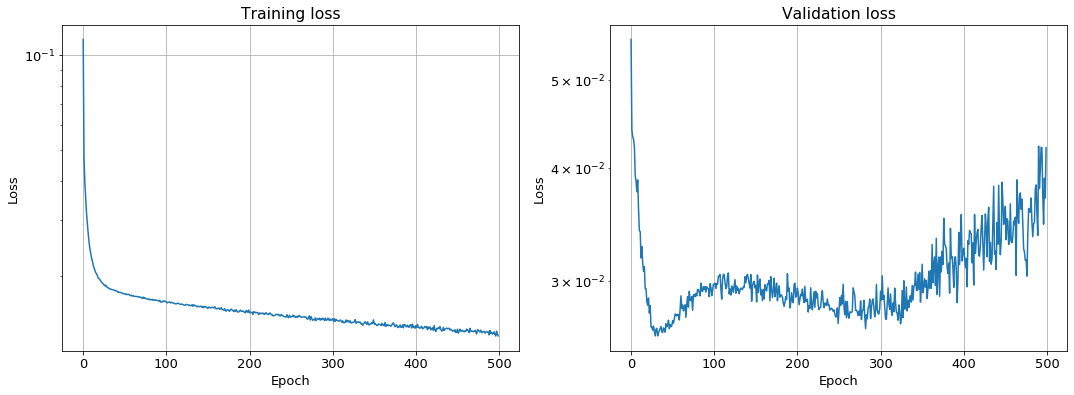

In [69]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

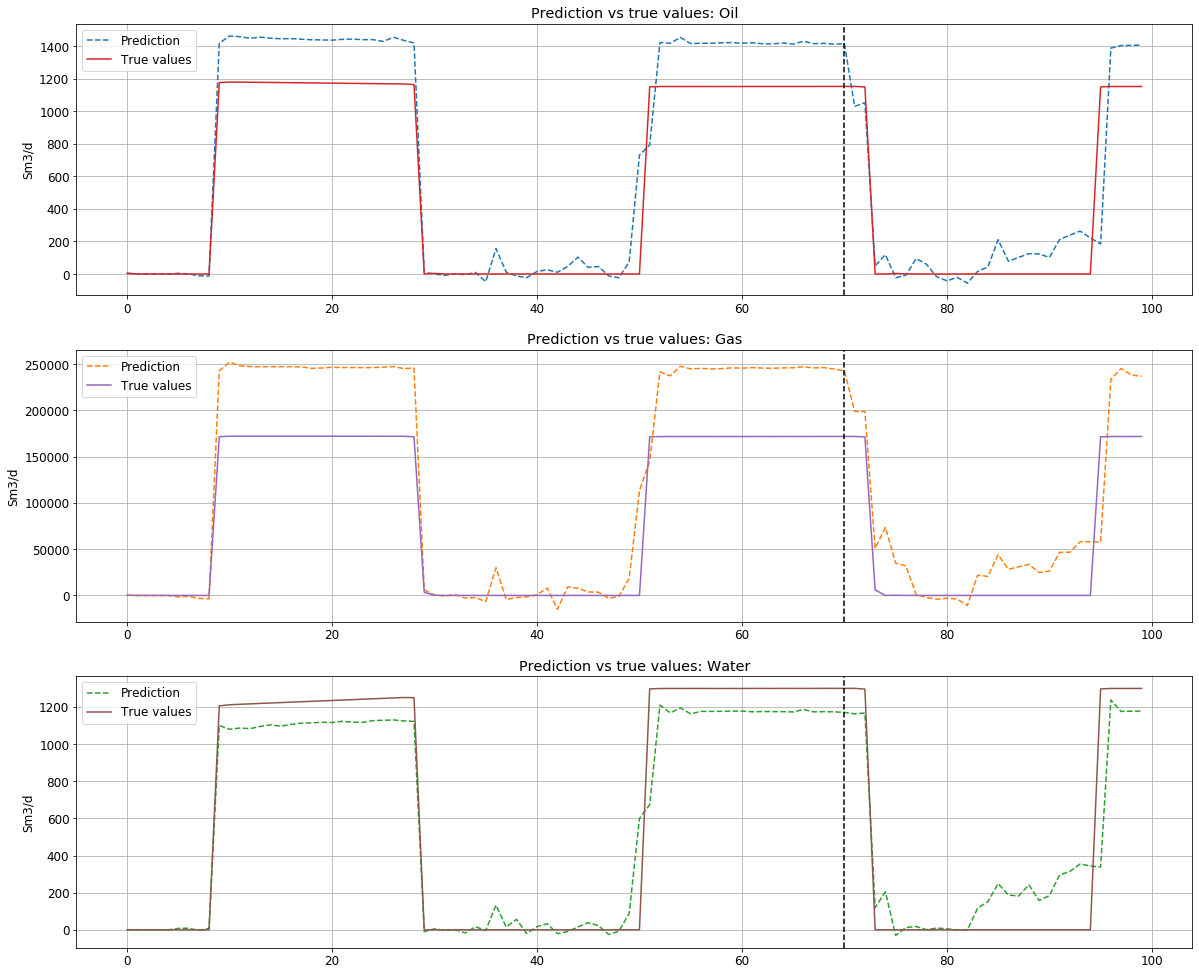

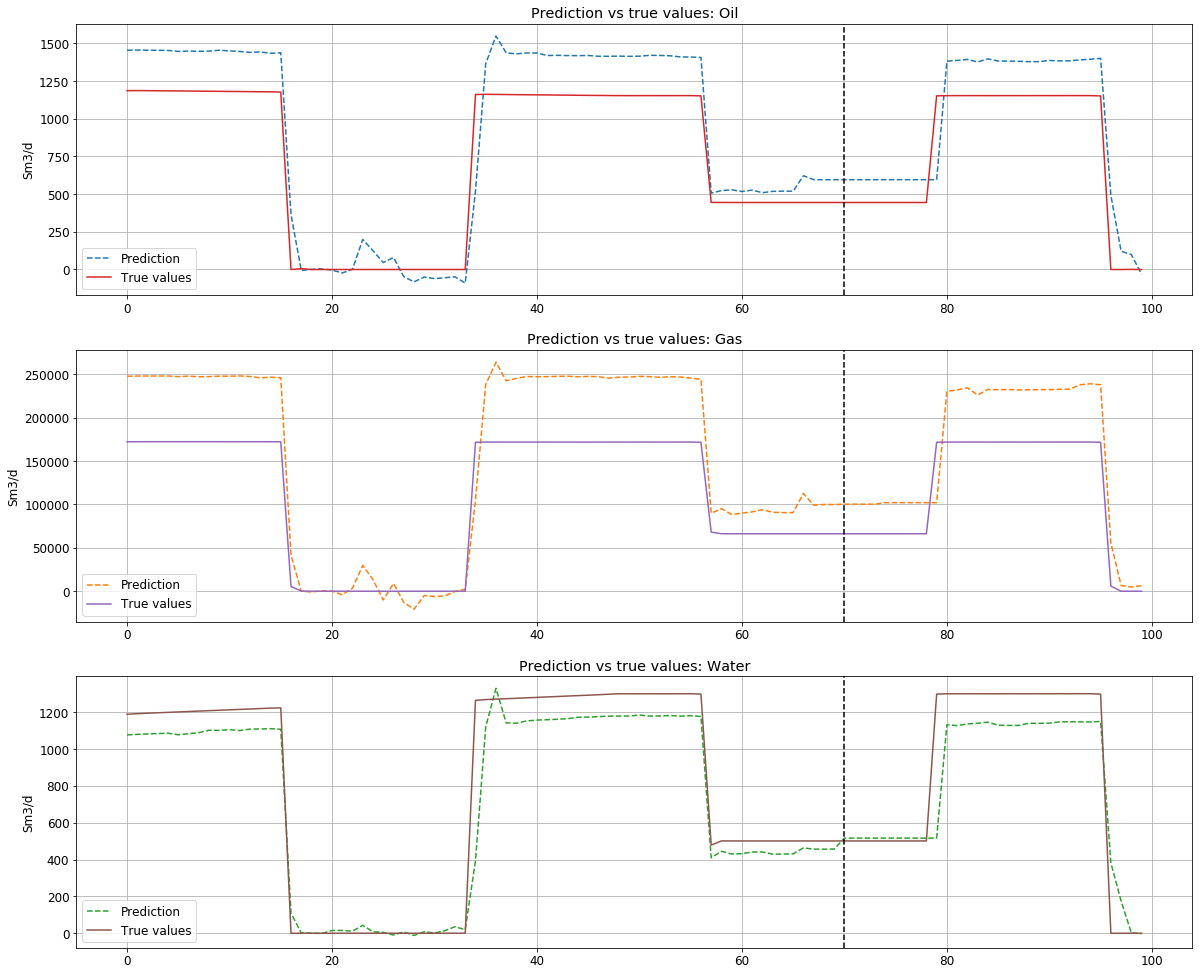

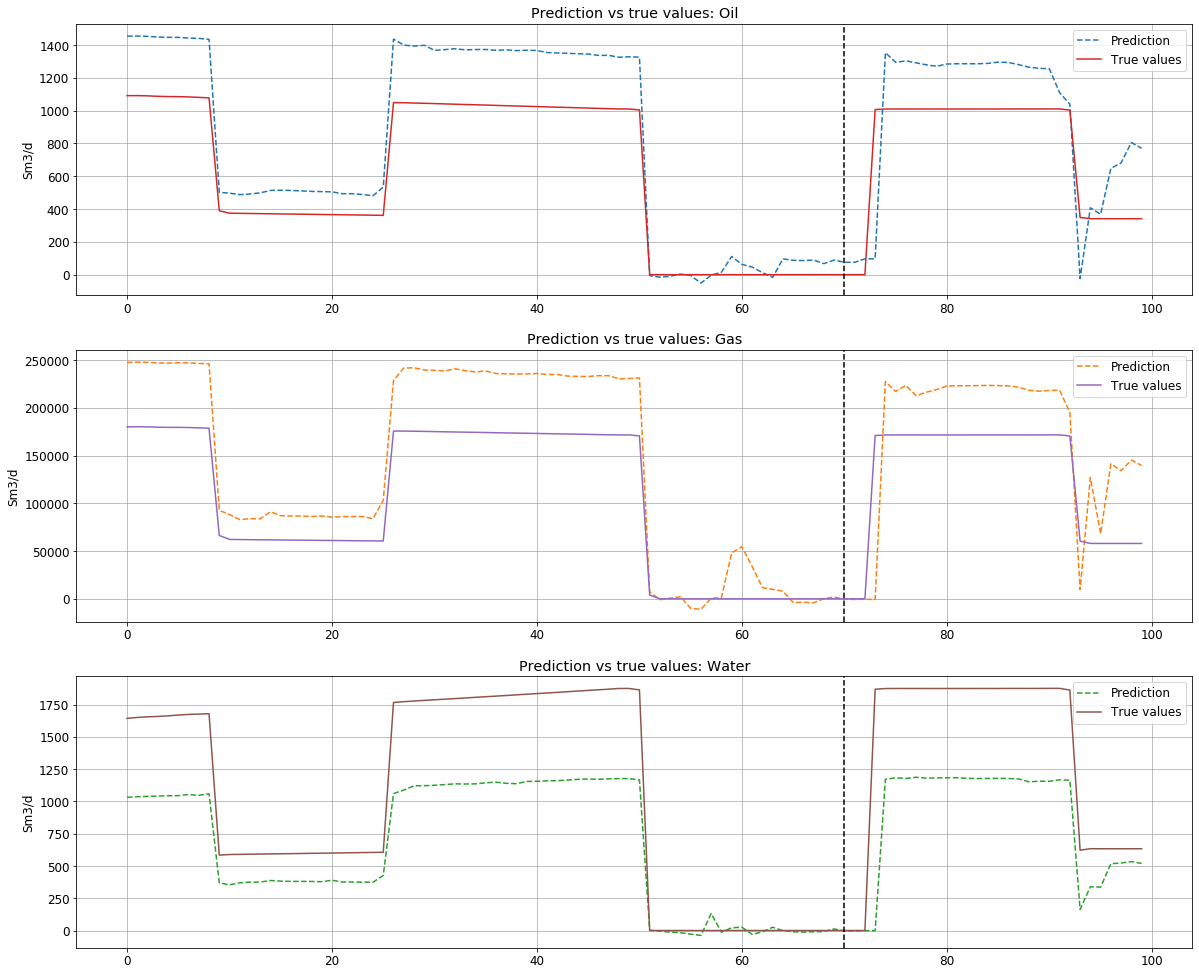

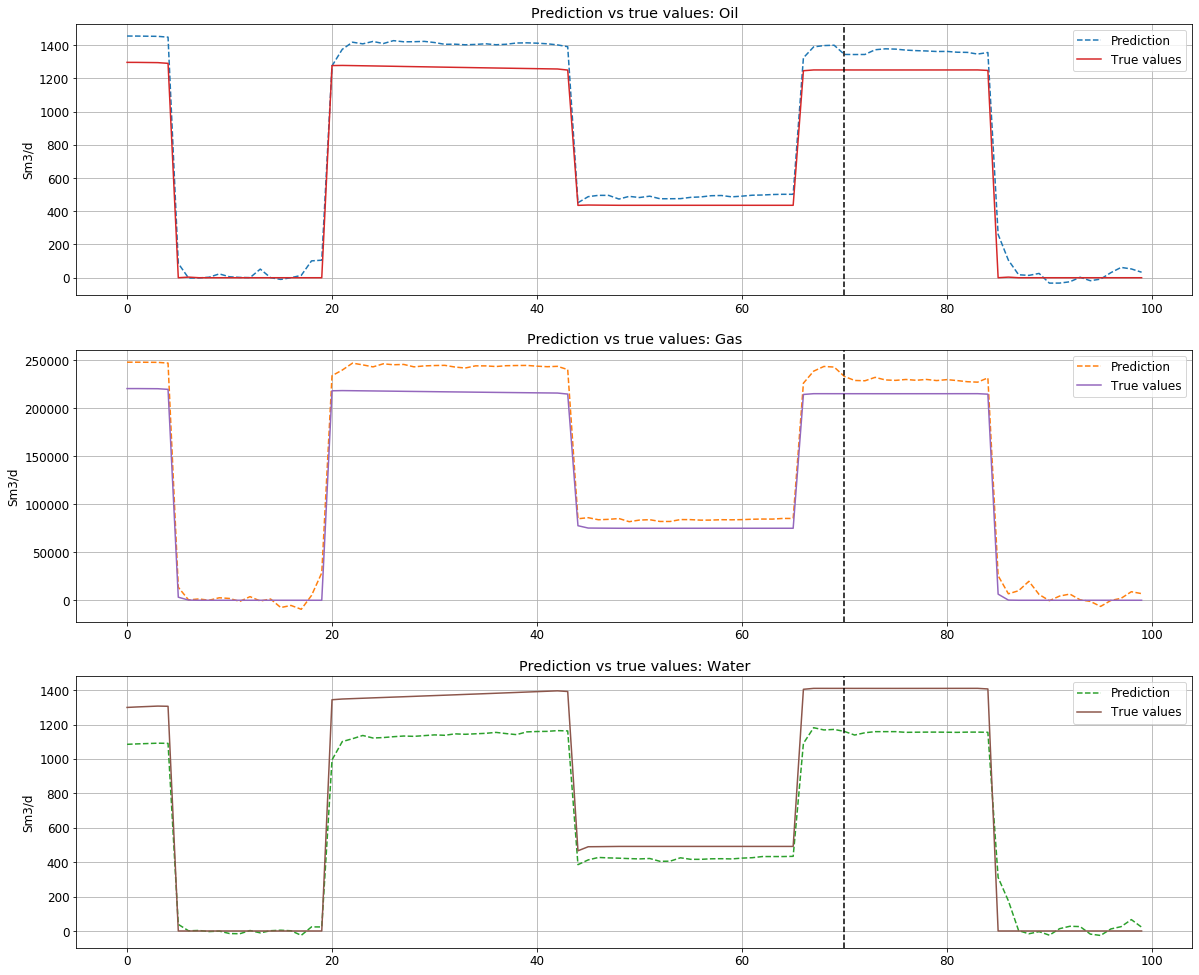

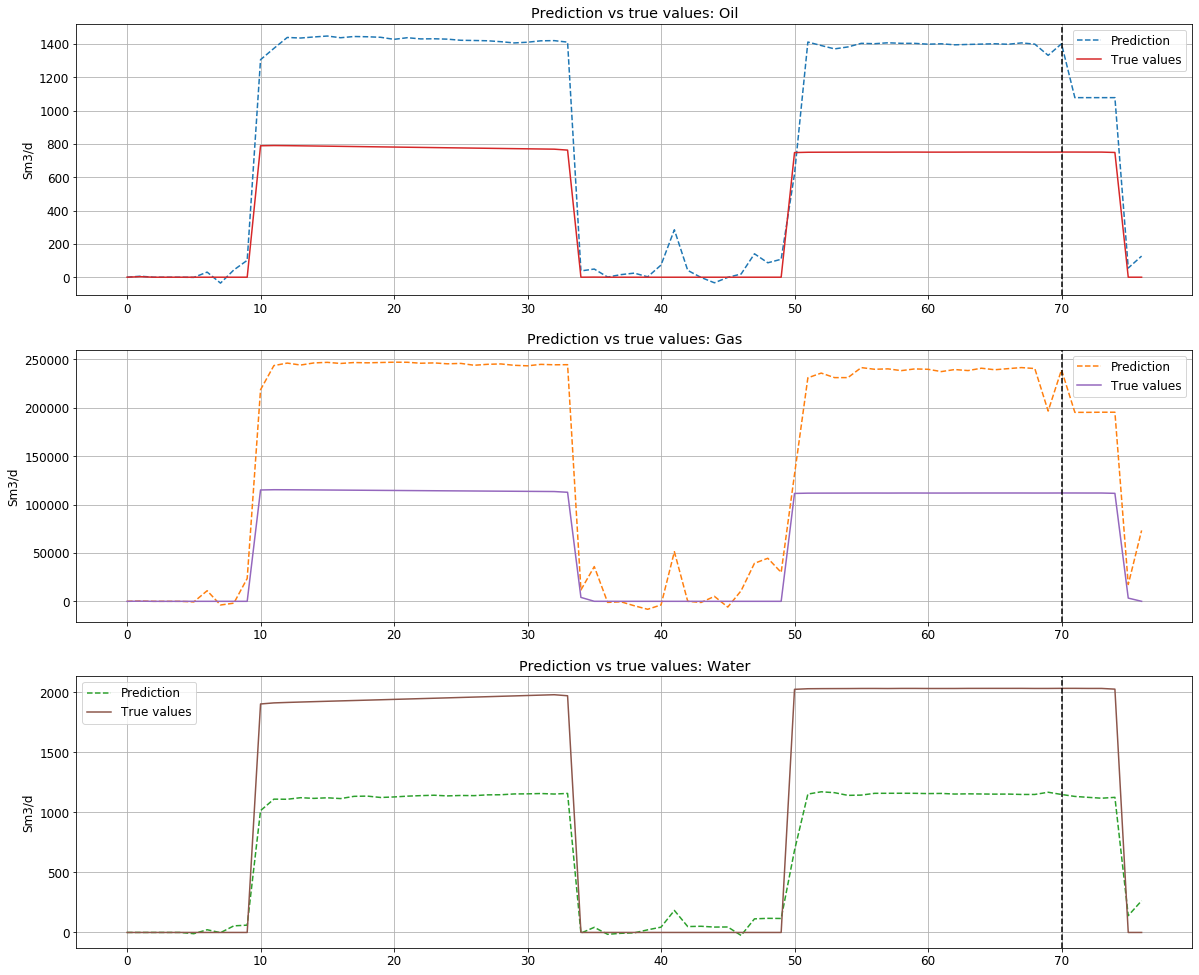

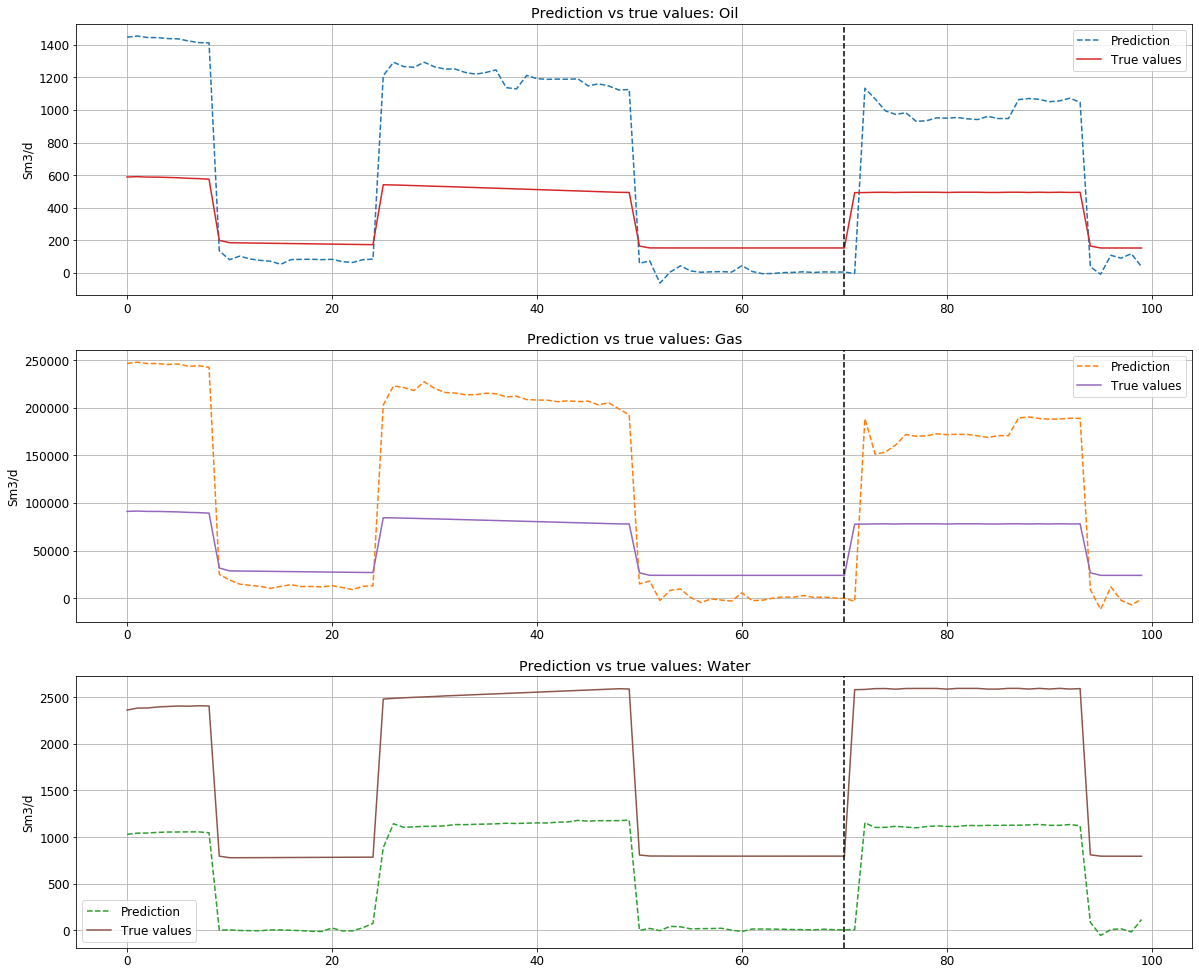

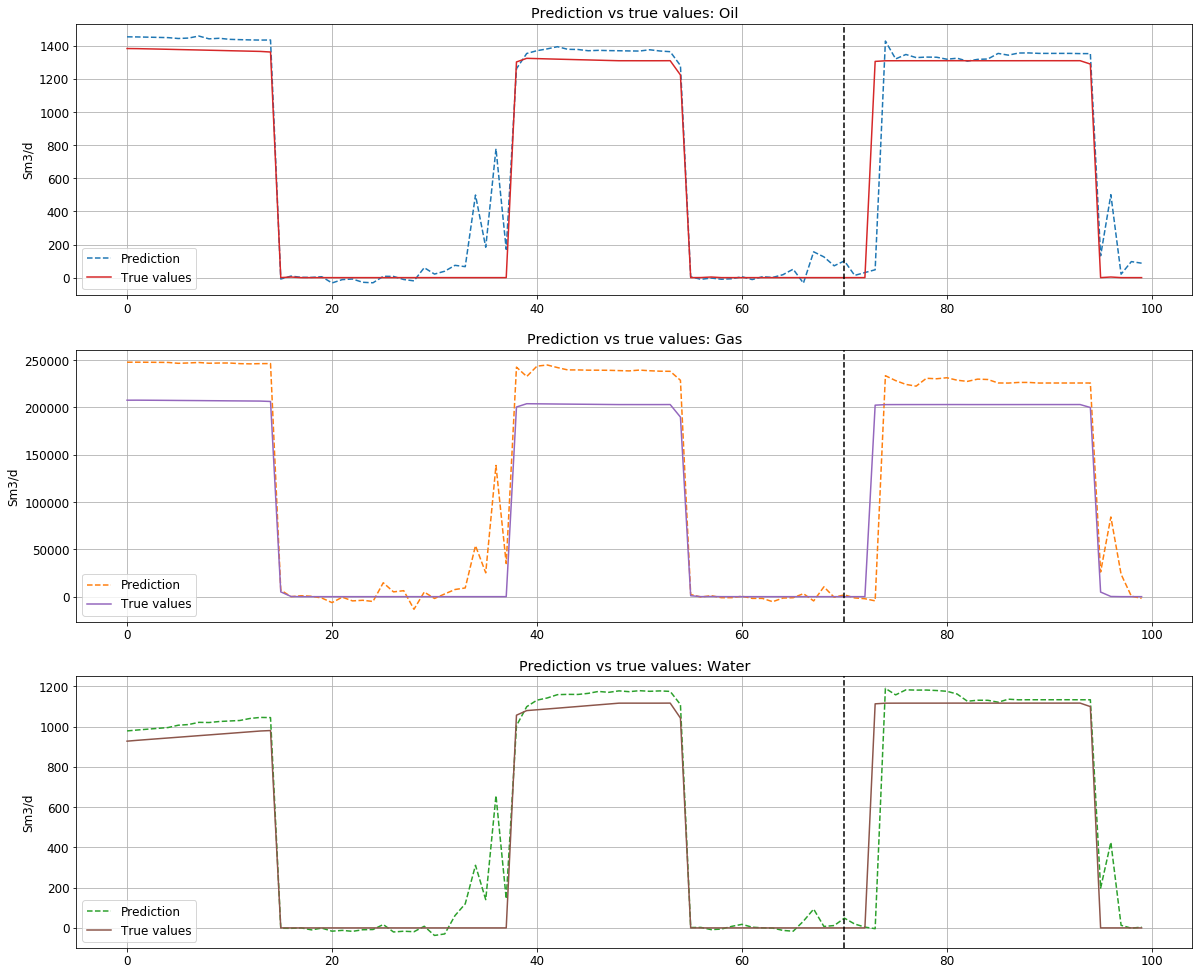

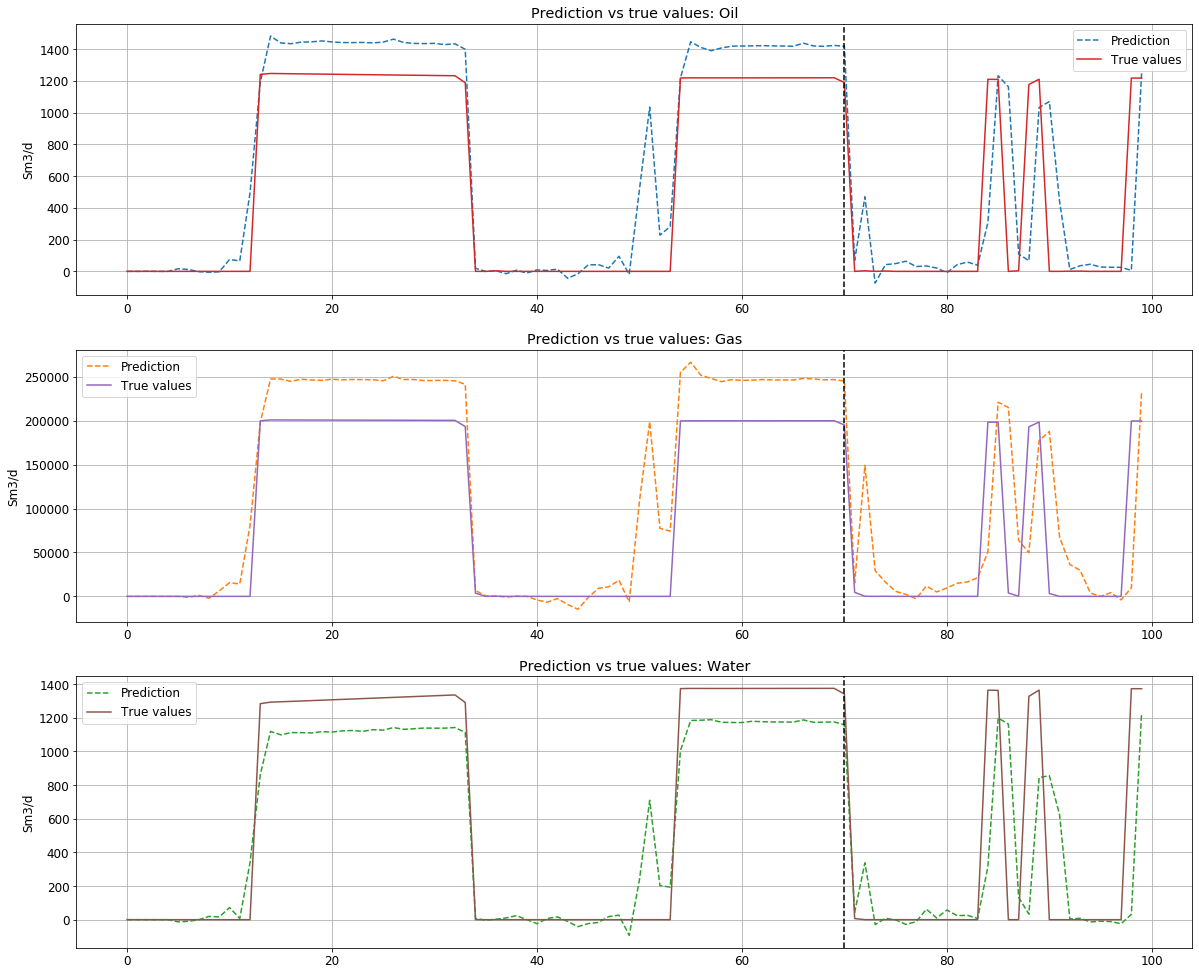

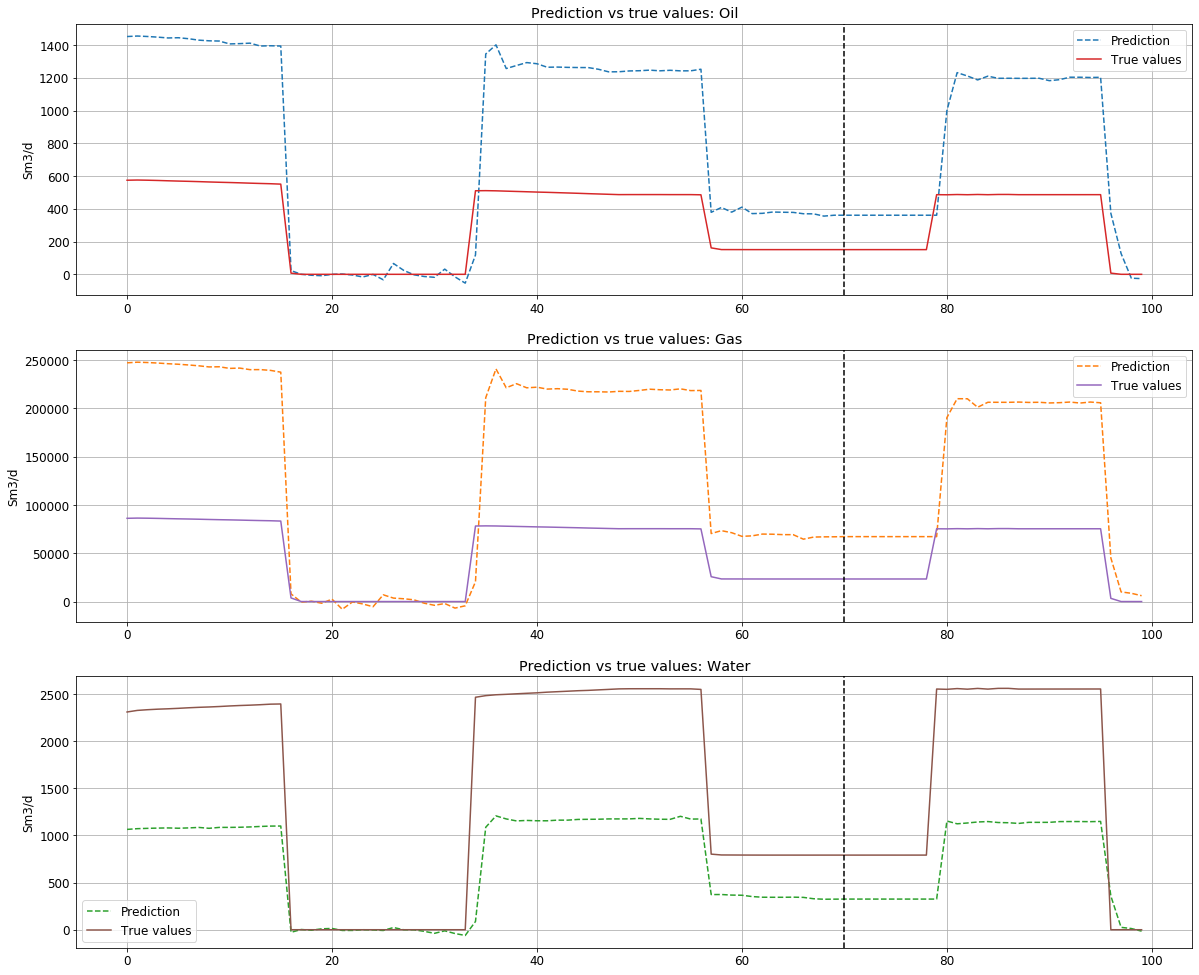

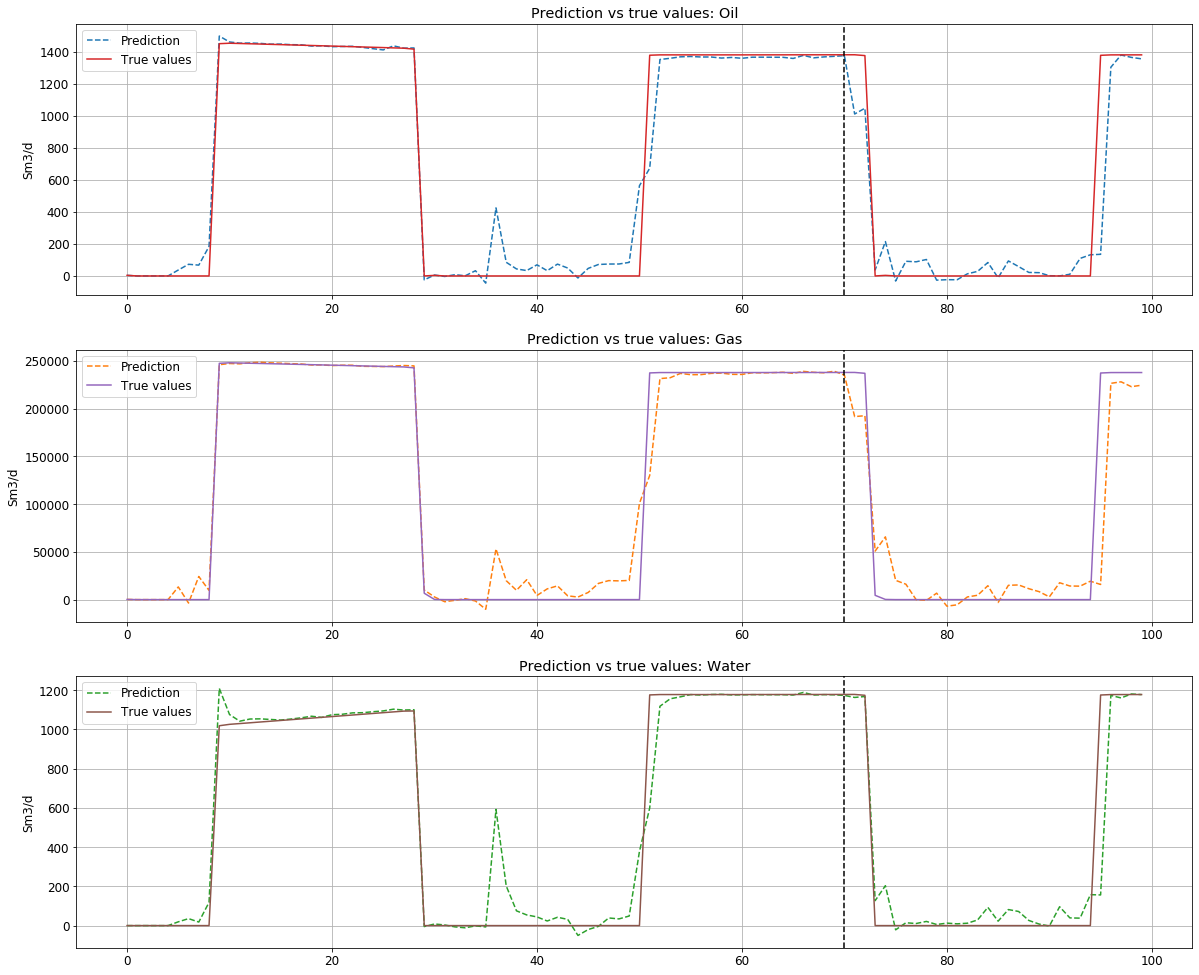

In [70]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [17]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')

# TCN

In [142]:
MODEL_NAME = 'TCN-1'
LOSS = 'mae'

In [143]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [152]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mae', optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 100
    batch_x = 30
    import tensorflow.keras.optimizers
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=10, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, max_depth=5, reg_alpha=1))

In [153]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [154]:
X_train_shuffle.shape, X_valid.shape

((29430, 5, 6), (1846, 5, 6))

In [155]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_train_shuffle, y_train_shuffle)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 29430 samples, validate on 1830 samples
Epoch 1/100
29430/29430 [==============================] - 13s 447us/sample - loss: 0.1610 - val_loss: 0.0334
Epoch 2/100
29430/29430 [==============================] - 10s 351us/sample - loss: 0.0576 - val_loss: 0.0327
Epoch 3/100
29430/29430 [==============================] - 10s 329us/sample - loss: 0.0452 - val_loss: 0.0309
Epoch 4/100
29430/29430 [==============================] - 10s 332us/sample - loss: 0.0400 - val_loss: 0.0331
Epoch 5/100
29430/29430 [==============================] - 10s 325us/sample - loss: 0.0373 - val_loss: 0.0293
Epoch 6/100
29430/29430 [==============================] - 10s 336us/sample - loss: 0.0351 - val_loss: 0.0283
Epoch 7/100
29430/29430 [==============================] - 10s 330us/sample - loss: 0.0338 - val_loss: 0.0294
Epoch 8/100
29430/29430 [==============================] - 10s 343us/sample - loss: 0.0323 - val_loss: 0.0311
Epoch 9/100
29430/29430 [==============================] - 10s 348us/sa

Epoch 75/100
29430/29430 [==============================] - 6s 213us/sample - loss: 0.0255 - val_loss: 0.0284
Epoch 76/100
29430/29430 [==============================] - 6s 210us/sample - loss: 0.0252 - val_loss: 0.0310
Epoch 77/100
29430/29430 [==============================] - 6s 209us/sample - loss: 0.0253 - val_loss: 0.0324
Epoch 78/100
29430/29430 [==============================] - 6s 210us/sample - loss: 0.0252 - val_loss: 0.0286
Epoch 79/100
29430/29430 [==============================] - 6s 210us/sample - loss: 0.0251 - val_loss: 0.0322
Epoch 80/100
29430/29430 [==============================] - 6s 213us/sample - loss: 0.0252 - val_loss: 0.0318
Epoch 81/100
29430/29430 [==============================] - 6s 212us/sample - loss: 0.0252 - val_loss: 0.0307
Epoch 82/100
29430/29430 [==============================] - 6s 212us/sample - loss: 0.0254 - val_loss: 0.0337
Epoch 83/100
29430/29430 [==============================] - 6s 214us/sample - loss: 0.0251 - val_loss: 0.0316
Epoch 84/1

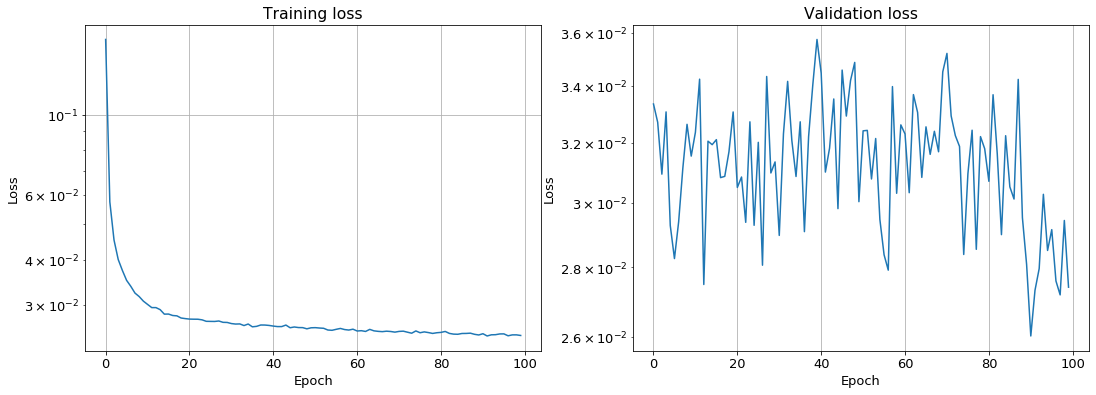

In [156]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

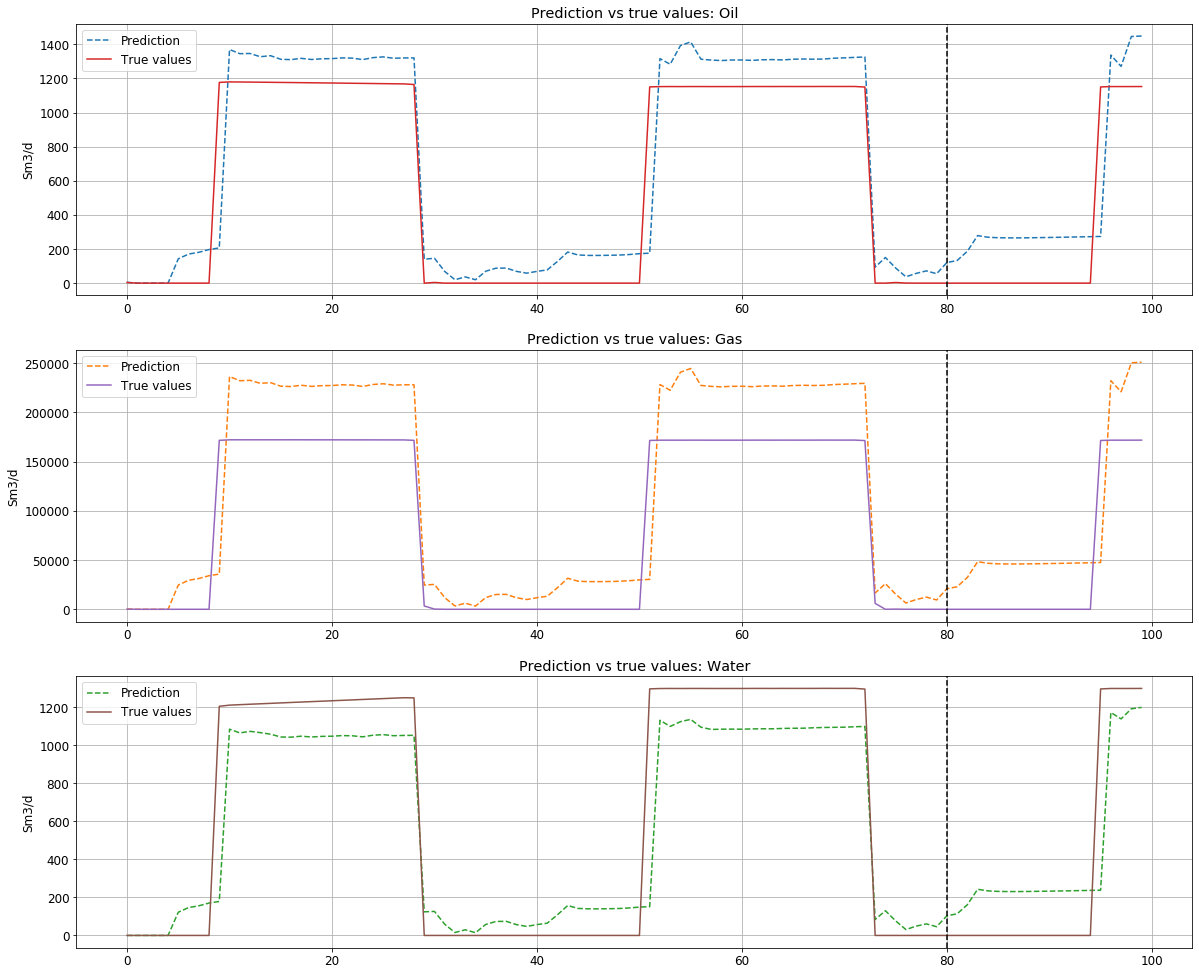

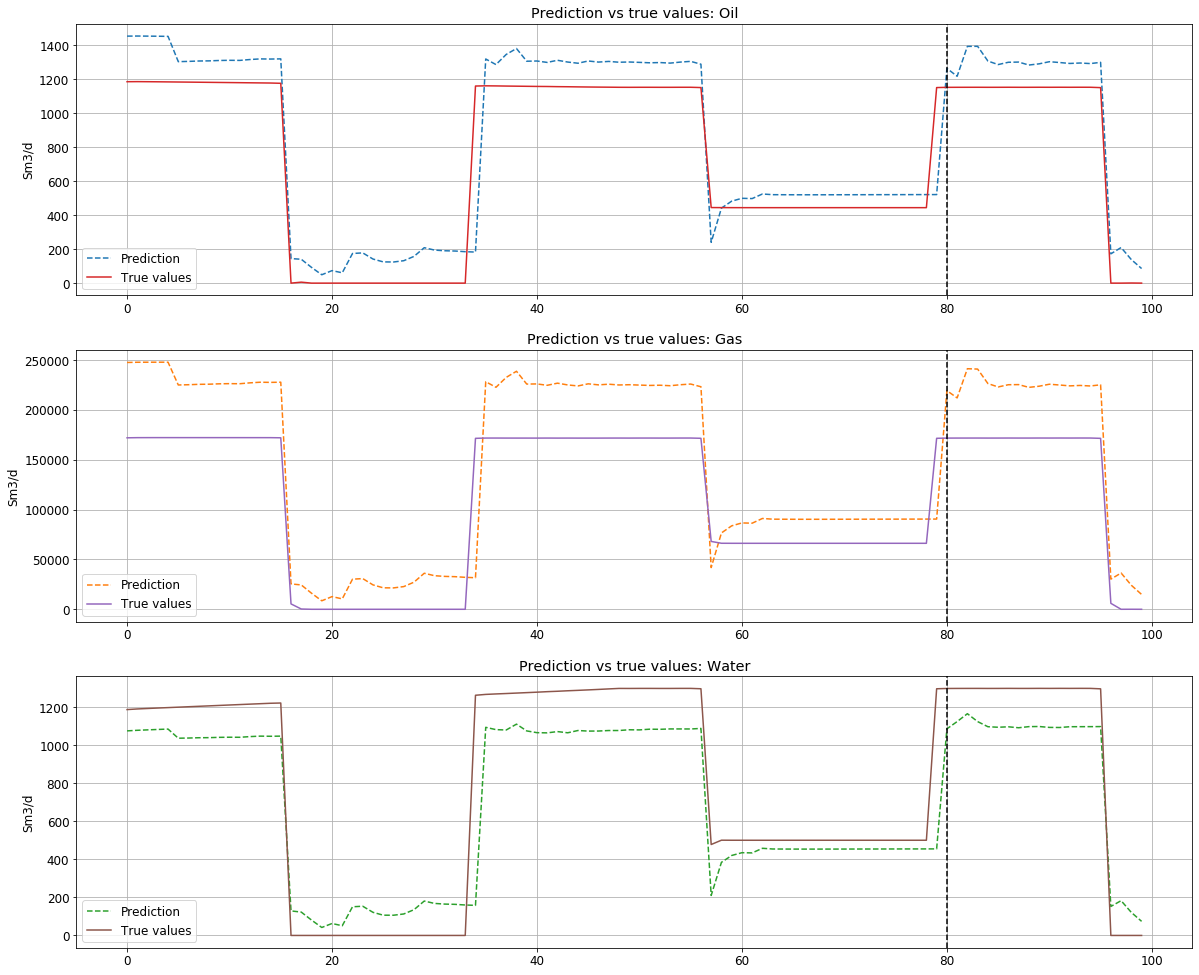

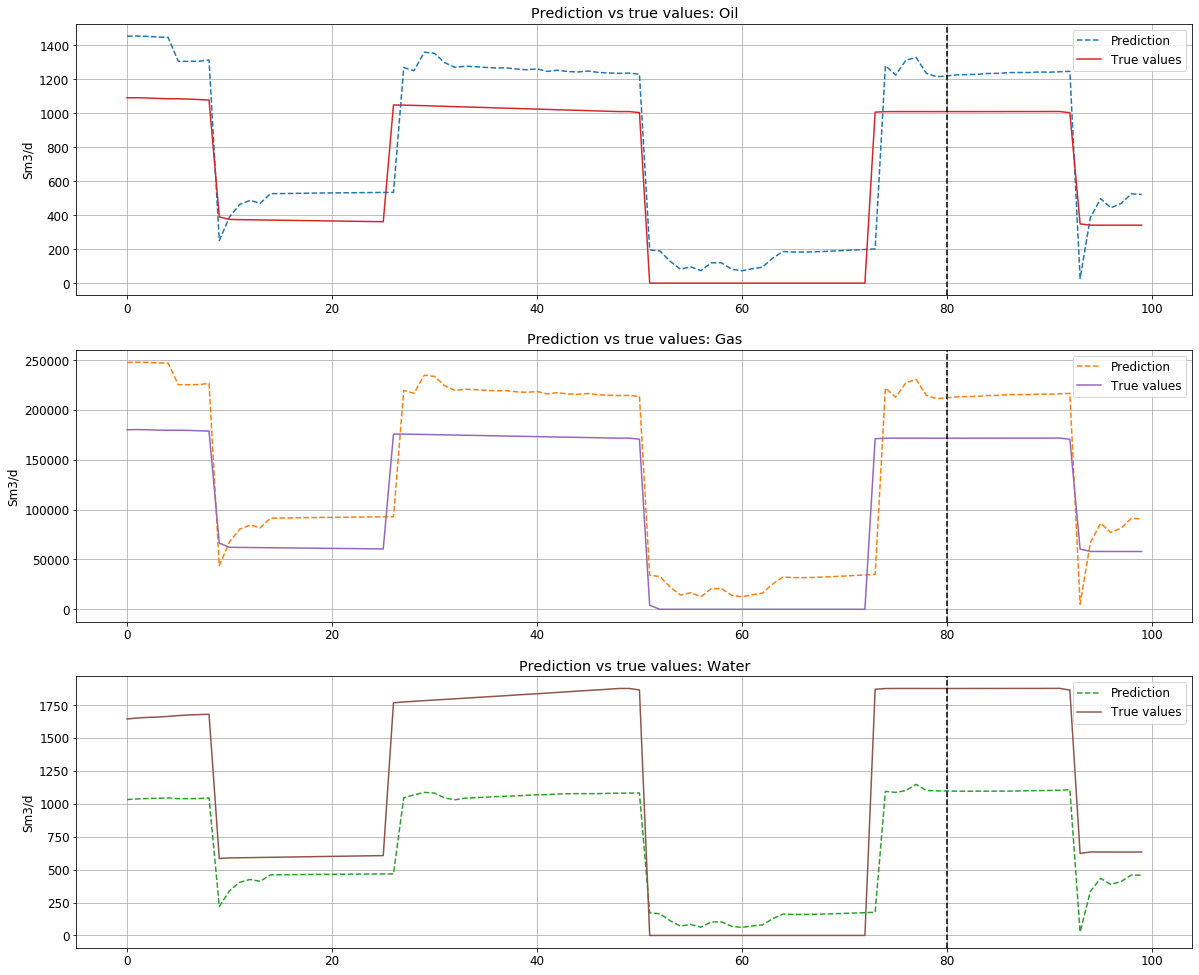

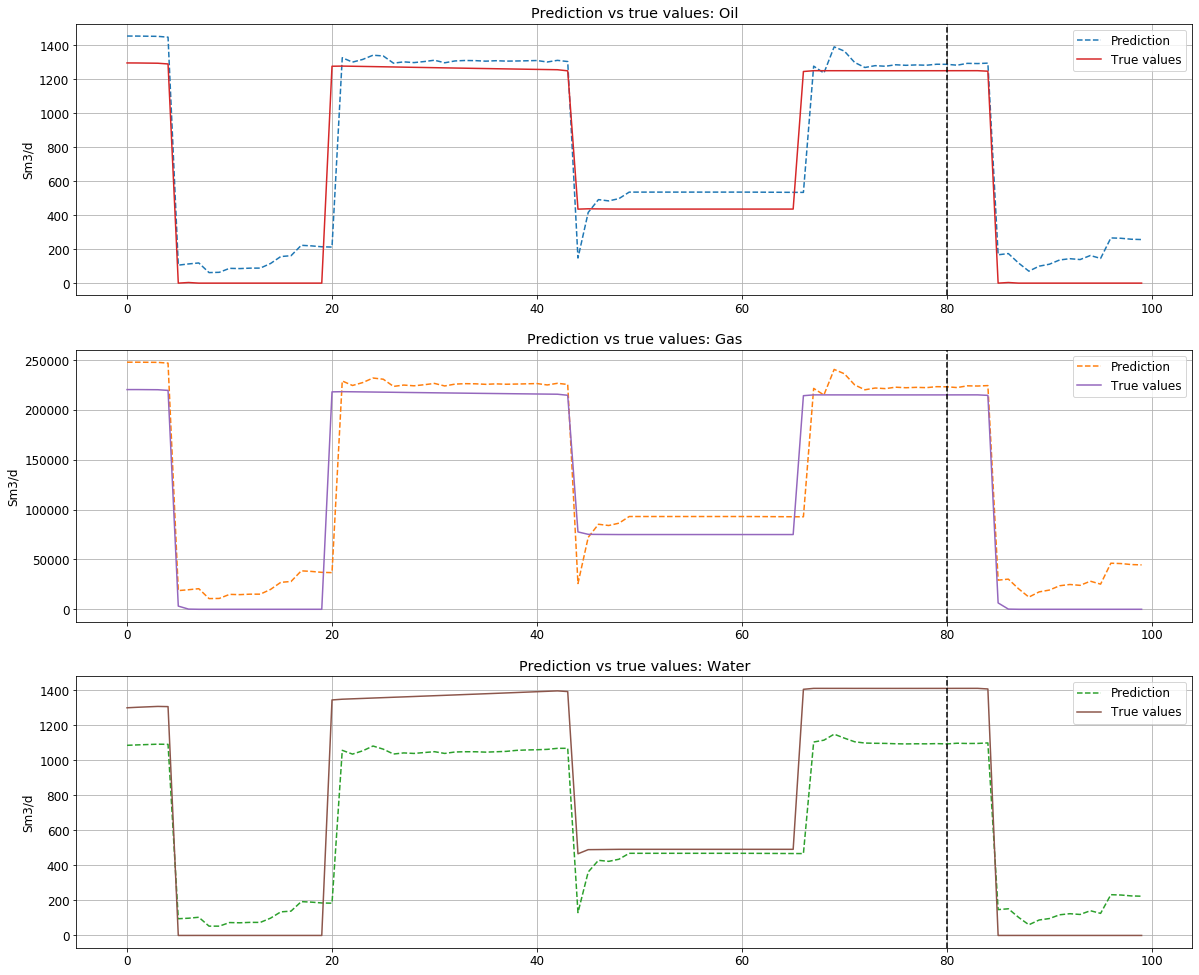

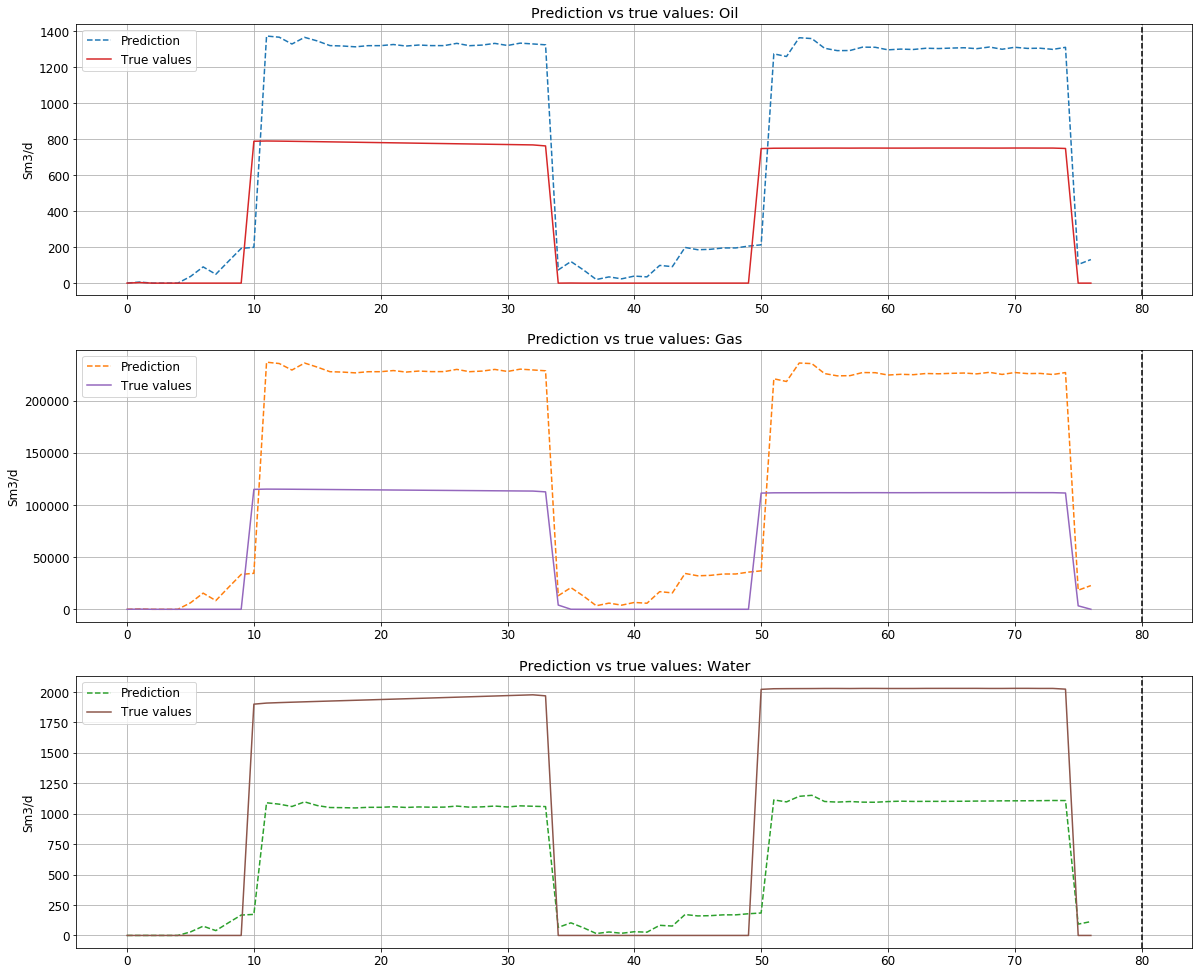

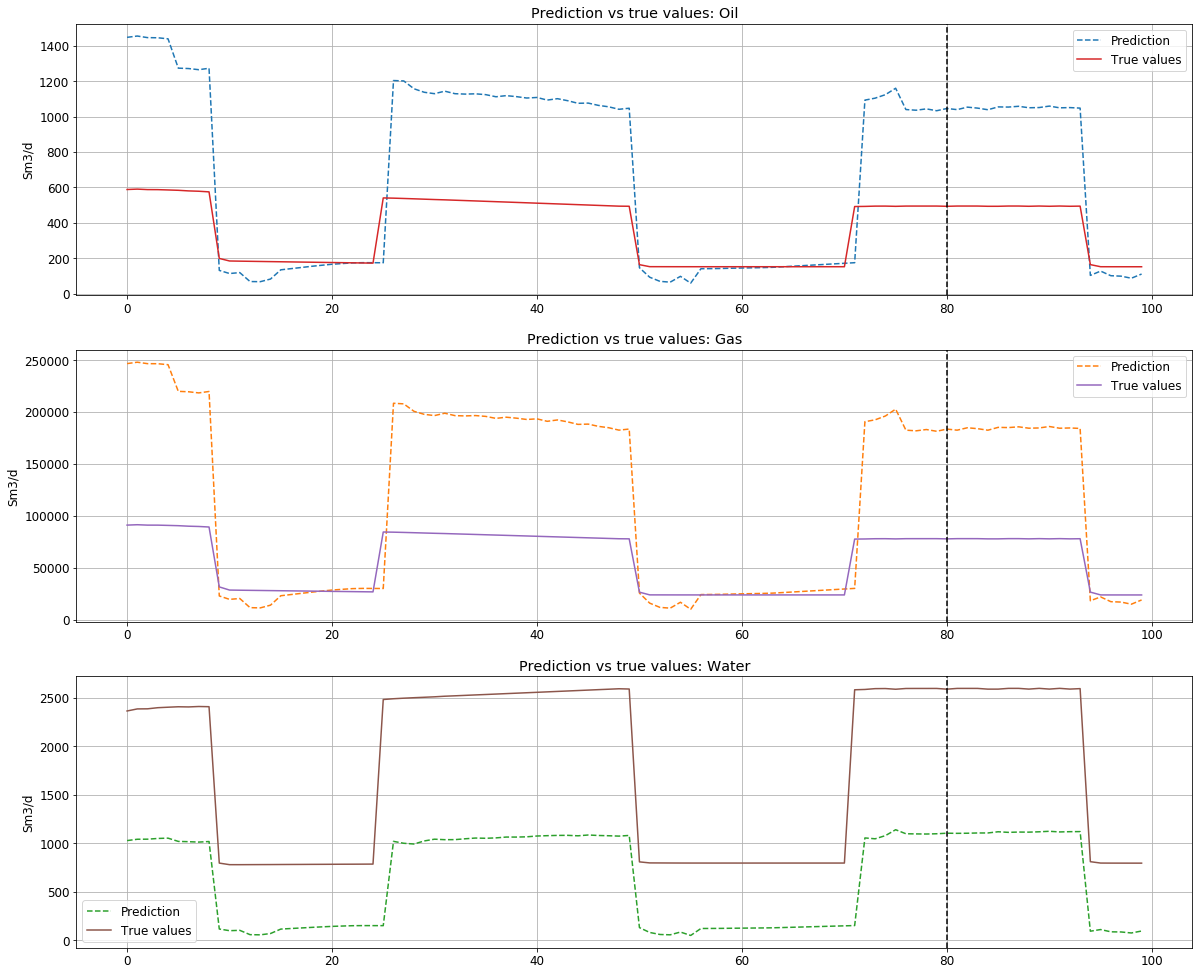

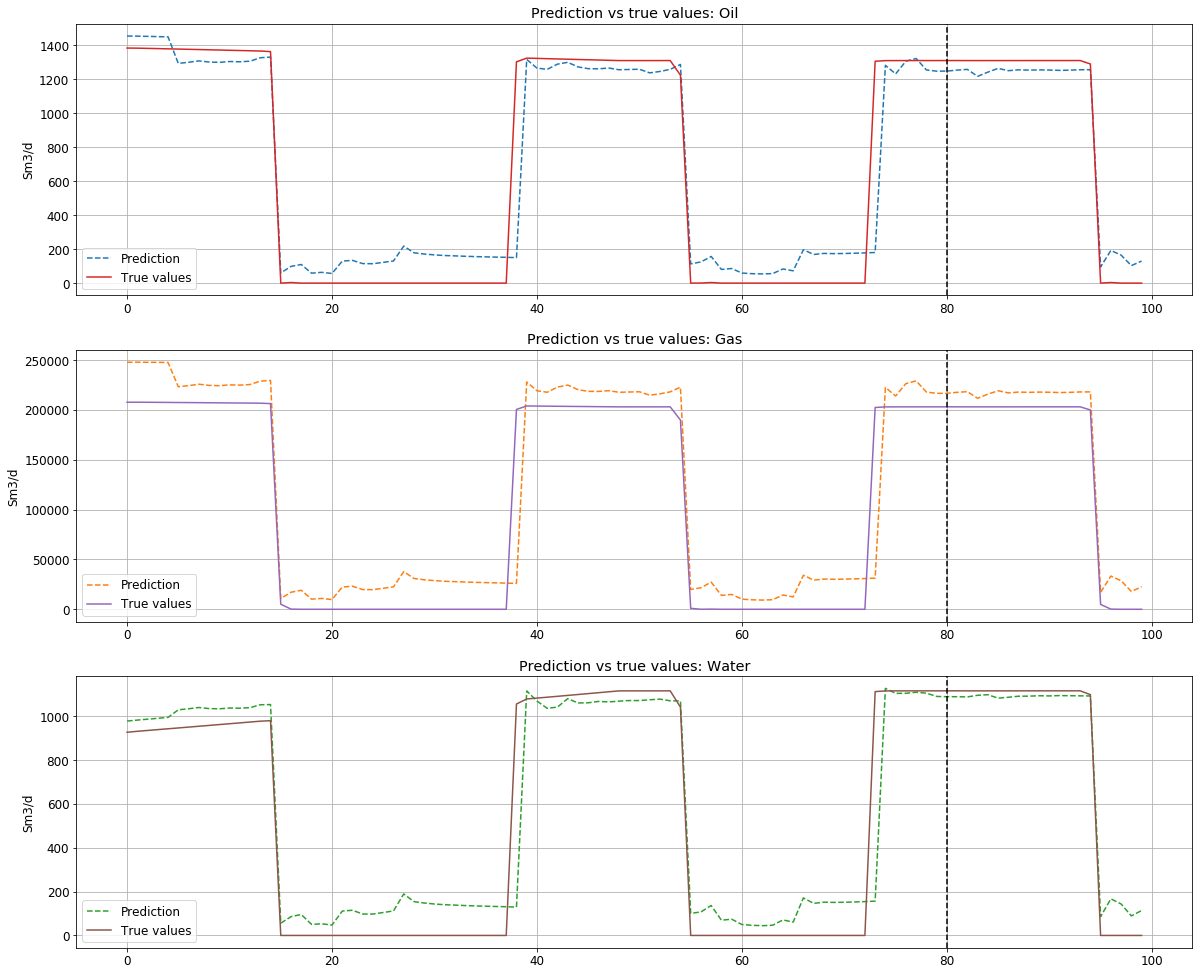

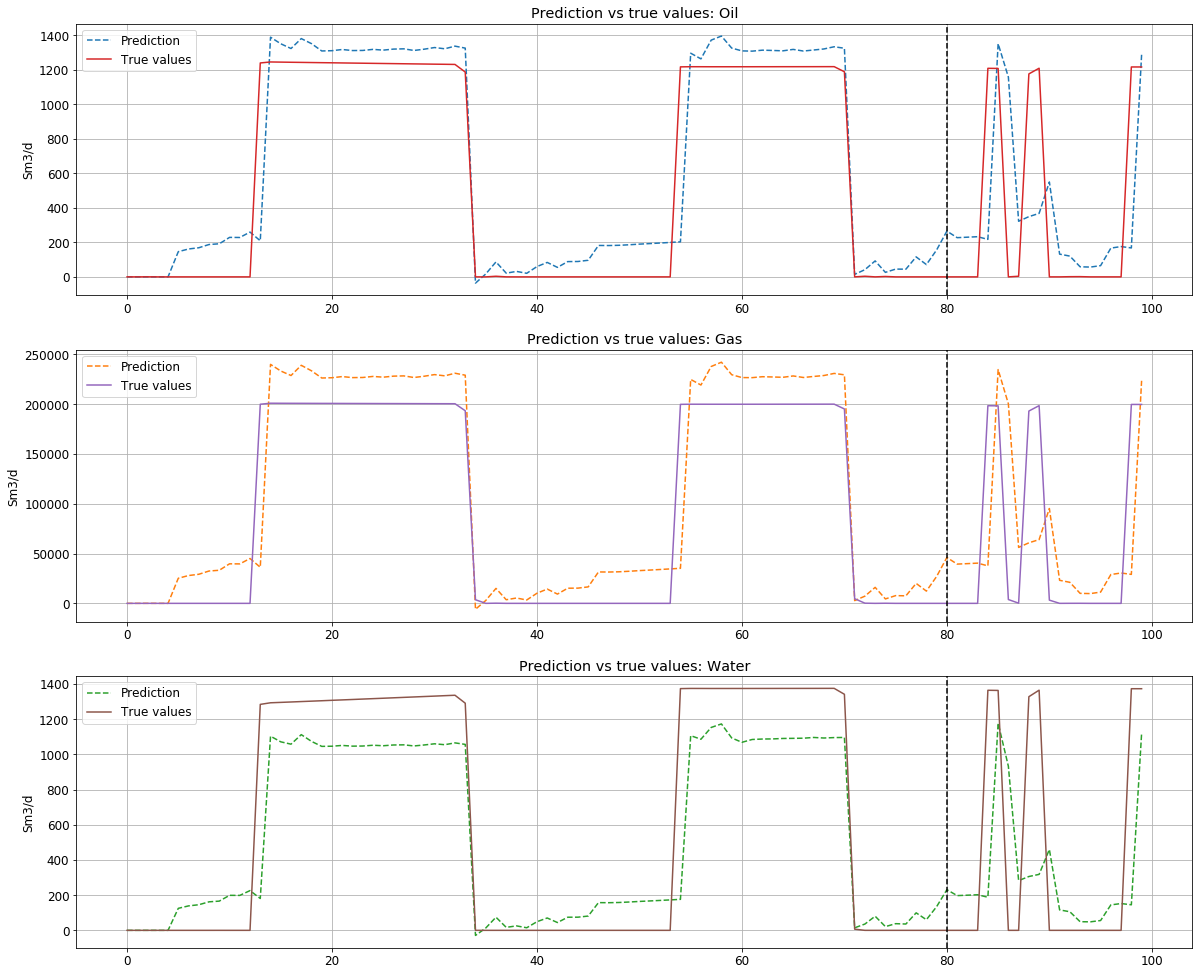

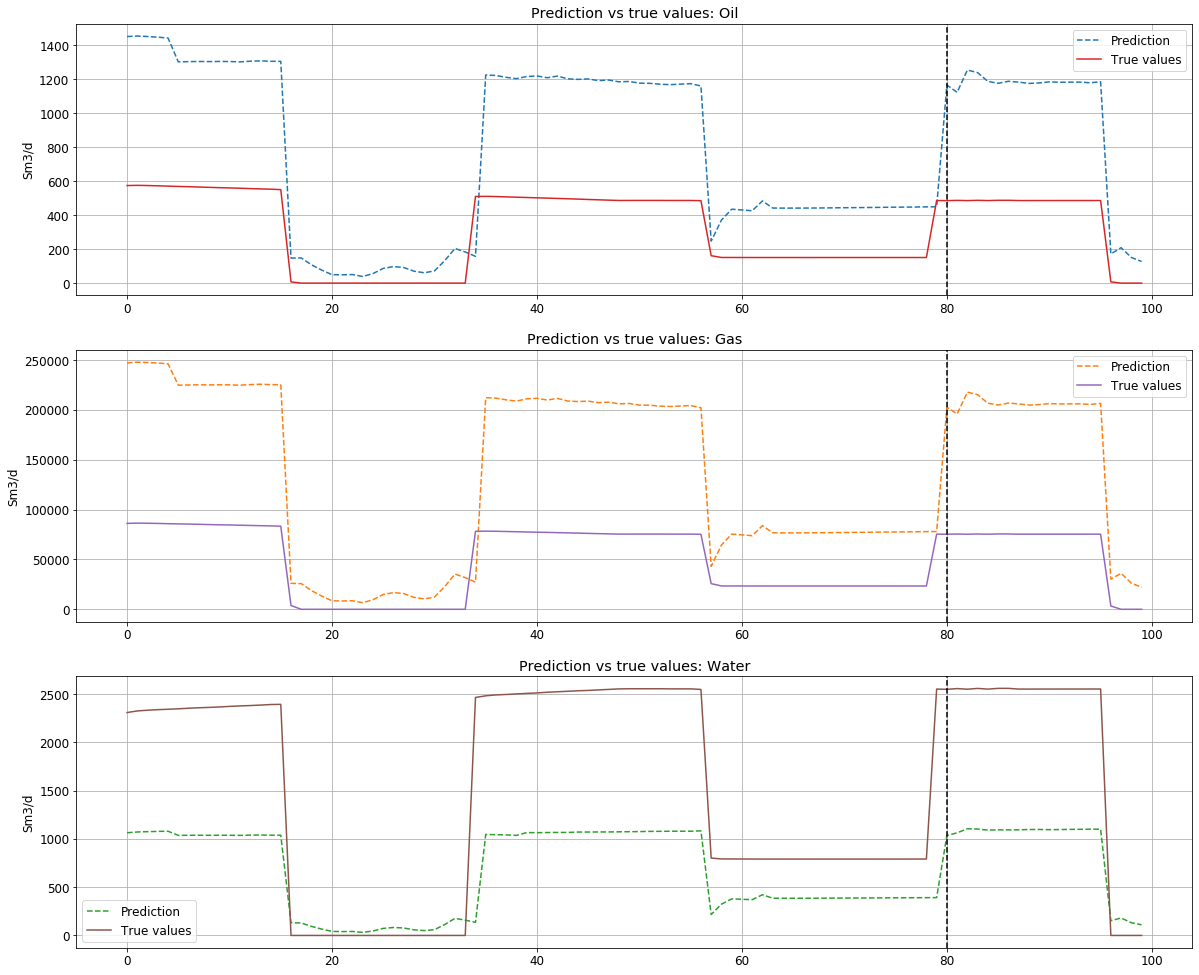

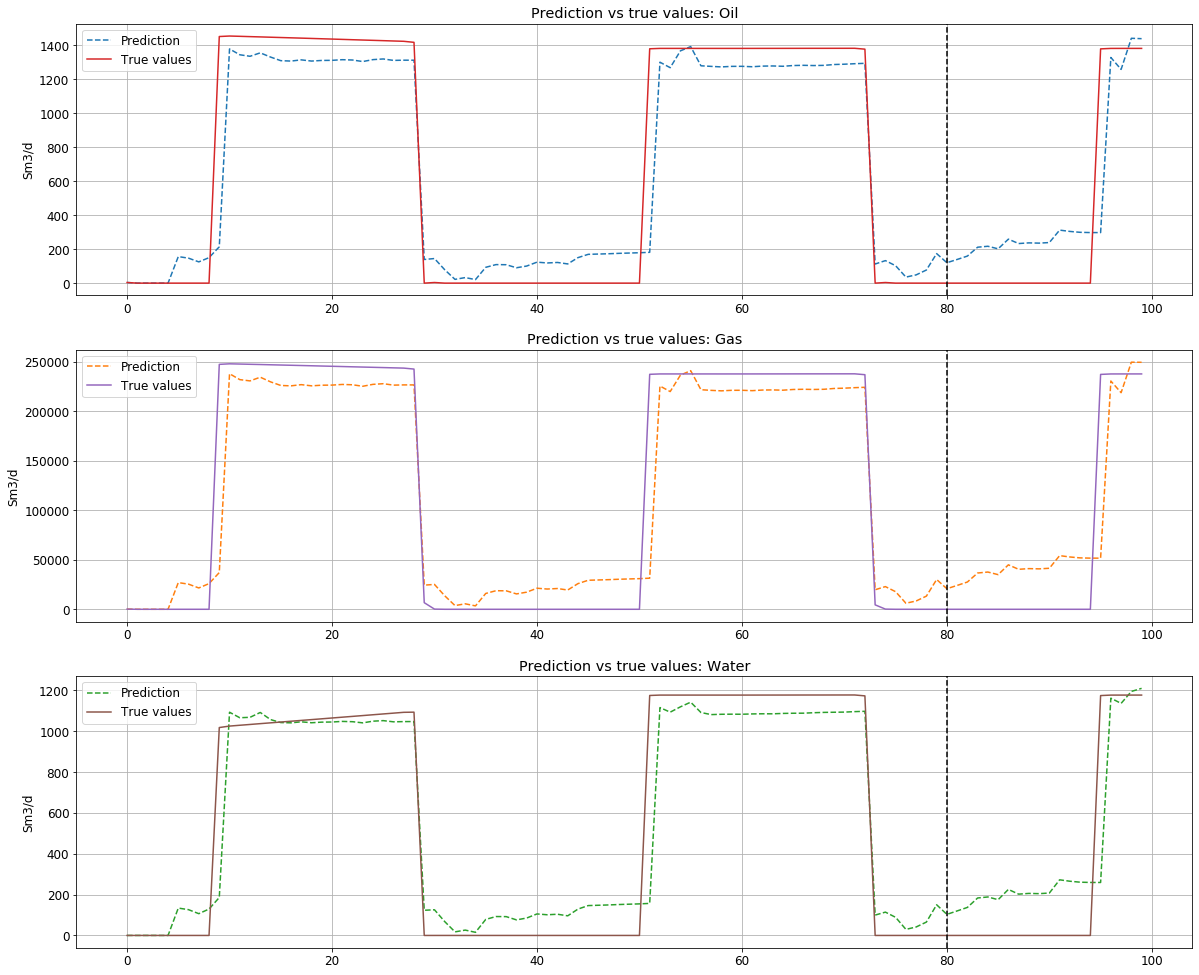

In [157]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [159]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')
print (f'{MODEL_NAME} saved')

TCN-1 saved


# MLP

In [160]:
MODEL_NAME = 'MLP-1'
LOSS = 'mae'

In [161]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [162]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mae', optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 100
    batch_x = 30
    import tensorflow.keras.optimizers
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=10, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, max_depth=5, reg_alpha=1))

In [163]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [164]:
X_train_shuffle.shape, X_valid.shape

((29430, 30), (1846, 30))

In [165]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_train_shuffle, y_train_shuffle)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 29430 samples, validate on 1846 samples
Epoch 1/500
29430/29430 [==============================] - 2s 77us/step - loss: 0.2130 - val_loss: 0.1222
Epoch 2/500
29430/29430 [==============================] - 2s 58us/step - loss: 0.1185 - val_loss: 0.1226
Epoch 3/500
29430/29430 [==============================] - 2s 57us/step - loss: 0.1019 - val_loss: 0.1271
Epoch 4/500
29430/29430 [==============================] - 2s 59us/step - loss: 0.0936 - val_loss: 0.1502
Epoch 5/500
29430/29430 [==============================] - 2s 62us/step - loss: 0.0873 - val_loss: 0.1567
Epoch 6/500
29430/29430 [==============================] - 3s 88us/step - loss: 0.0823 - val_loss: 0.1567
Epoch 7/500
29430/29430 [==============================] - 3s 87us/step - loss: 0.0773 - val_loss: 0.1438
Epoch 8/500
29430/29430 [==============================] - 3s 90us/step - loss: 0.0730 - val_loss: 0.1388
Epoch 9/500
29430/29430 [==============================] - 3s 88us/step - loss: 0.0687 - val_loss: 0.13

29430/29430 [==============================] - 3s 88us/step - loss: 0.0344 - val_loss: 0.0384
Epoch 78/500
29430/29430 [==============================] - 3s 91us/step - loss: 0.0344 - val_loss: 0.0406
Epoch 79/500
29430/29430 [==============================] - 3s 89us/step - loss: 0.0344 - val_loss: 0.0404
Epoch 80/500
29430/29430 [==============================] - 3s 89us/step - loss: 0.0342 - val_loss: 0.0400
Epoch 81/500
29430/29430 [==============================] - 3s 88us/step - loss: 0.0342 - val_loss: 0.0385
Epoch 82/500
29430/29430 [==============================] - 3s 88us/step - loss: 0.0342 - val_loss: 0.0389
Epoch 83/500
29430/29430 [==============================] - 3s 88us/step - loss: 0.0341 - val_loss: 0.0395
Epoch 84/500
29430/29430 [==============================] - 2s 84us/step - loss: 0.0342 - val_loss: 0.0387
Epoch 85/500
29430/29430 [==============================] - ETA: 0s - loss: 0.034 - 3s 87us/step - loss: 0.0341 - val_loss: 0.0414
Epoch 86/500
29430/29430 [

29430/29430 [==============================] - 3s 85us/step - loss: 0.0329 - val_loss: 0.0404
Epoch 153/500
29430/29430 [==============================] - 3s 87us/step - loss: 0.0329 - val_loss: 0.0397
Epoch 154/500
29430/29430 [==============================] - 2s 81us/step - loss: 0.0330 - val_loss: 0.0404
Epoch 155/500
29430/29430 [==============================] - 2s 85us/step - loss: 0.0329 - val_loss: 0.0393
Epoch 156/500
29430/29430 [==============================] - 2s 83us/step - loss: 0.0329 - val_loss: 0.0404
Epoch 157/500
29430/29430 [==============================] - 2s 84us/step - loss: 0.0329 - val_loss: 0.0388
Epoch 158/500
29430/29430 [==============================] - 2s 84us/step - loss: 0.0329 - val_loss: 0.0398
Epoch 159/500
29430/29430 [==============================] - 3s 85us/step - loss: 0.0328 - val_loss: 0.0371
Epoch 160/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0329 - val_loss: 0.0395
Epoch 161/500
29430/29430 [===============

Epoch 228/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0323 - val_loss: 0.0386
Epoch 229/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0323 - val_loss: 0.0400
Epoch 230/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0323 - val_loss: 0.0387
Epoch 231/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0322 - val_loss: 0.0387
Epoch 232/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0323 - val_loss: 0.0388
Epoch 233/500
29430/29430 [==============================] - 3s 85us/step - loss: 0.0322 - val_loss: 0.0348
Epoch 234/500
29430/29430 [==============================] - 3s 85us/step - loss: 0.0322 - val_loss: 0.0393
Epoch 235/500
29430/29430 [==============================] - 3s 85us/step - loss: 0.0323 - val_loss: 0.0386
Epoch 236/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0322 - val_loss: 0.0380
Epoch 237/500
29430/29430 [=

Epoch 304/500
29430/29430 [==============================] - 3s 85us/step - loss: 0.0318 - val_loss: 0.0367
Epoch 305/500
29430/29430 [==============================] - 2s 85us/step - loss: 0.0318 - val_loss: 0.0362
Epoch 306/500
29430/29430 [==============================] - 3s 86us/step - loss: 0.0318 - val_loss: 0.0345
Epoch 307/500
29430/29430 [==============================] - 3s 87us/step - loss: 0.0319 - val_loss: 0.0350
Epoch 308/500
29430/29430 [==============================] - 2s 84us/step - loss: 0.0318 - val_loss: 0.0352
Epoch 309/500
29430/29430 [==============================] - 3s 85us/step - loss: 0.0318 - val_loss: 0.0346
Epoch 310/500
29430/29430 [==============================] - 3s 85us/step - loss: 0.0318 - val_loss: 0.0383
Epoch 311/500
29430/29430 [==============================] - 2s 84us/step - loss: 0.0318 - val_loss: 0.0359
Epoch 312/500
29430/29430 [==============================] - 2s 83us/step - loss: 0.0319 - val_loss: 0.0359
Epoch 313/500
29430/29430 [=

29430/29430 [==============================] - 2s 73us/step - loss: 0.0316 - val_loss: 0.0340
Epoch 380/500
29430/29430 [==============================] - 2s 68us/step - loss: 0.0316 - val_loss: 0.0339
Epoch 381/500
29430/29430 [==============================] - 2s 68us/step - loss: 0.0316 - val_loss: 0.0341
Epoch 382/500
29430/29430 [==============================] - 2s 65us/step - loss: 0.0316 - val_loss: 0.0345
Epoch 383/500
29430/29430 [==============================] - 2s 65us/step - loss: 0.0315 - val_loss: 0.0338
Epoch 384/500
29430/29430 [==============================] - 2s 66us/step - loss: 0.0316 - val_loss: 0.0342
Epoch 385/500
29430/29430 [==============================] - 2s 63us/step - loss: 0.0316 - val_loss: 0.0340
Epoch 386/500
29430/29430 [==============================] - 2s 66us/step - loss: 0.0315 - val_loss: 0.0341
Epoch 387/500
29430/29430 [==============================] - 2s 68us/step - loss: 0.0315 - val_loss: 0.0337
Epoch 388/500
29430/29430 [===============

29430/29430 [==============================] - 2s 77us/step - loss: 0.0313 - val_loss: 0.0339
Epoch 455/500
29430/29430 [==============================] - 2s 77us/step - loss: 0.0314 - val_loss: 0.0339
Epoch 456/500
29430/29430 [==============================] - 2s 74us/step - loss: 0.0314 - val_loss: 0.0339
Epoch 457/500
29430/29430 [==============================] - 2s 73us/step - loss: 0.0314 - val_loss: 0.0340
Epoch 458/500
29430/29430 [==============================] - 2s 73us/step - loss: 0.0314 - val_loss: 0.0345
Epoch 459/500
29430/29430 [==============================] - 2s 75us/step - loss: 0.0314 - val_loss: 0.0342
Epoch 460/500
29430/29430 [==============================] - 2s 73us/step - loss: 0.0313 - val_loss: 0.0333
Epoch 461/500
29430/29430 [==============================] - 2s 73us/step - loss: 0.0313 - val_loss: 0.0338
Epoch 462/500
29430/29430 [==============================] - 2s 74us/step - loss: 0.0313 - val_loss: 0.0341
Epoch 463/500
29430/29430 [===============

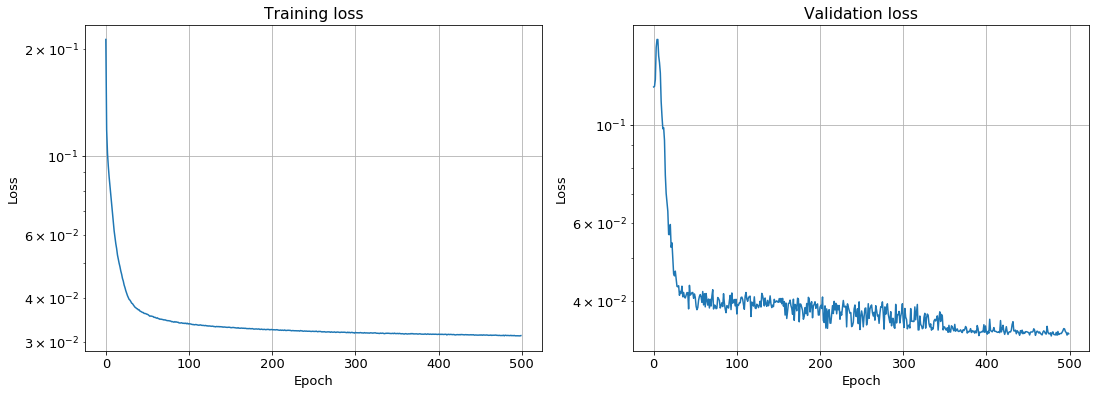

In [166]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

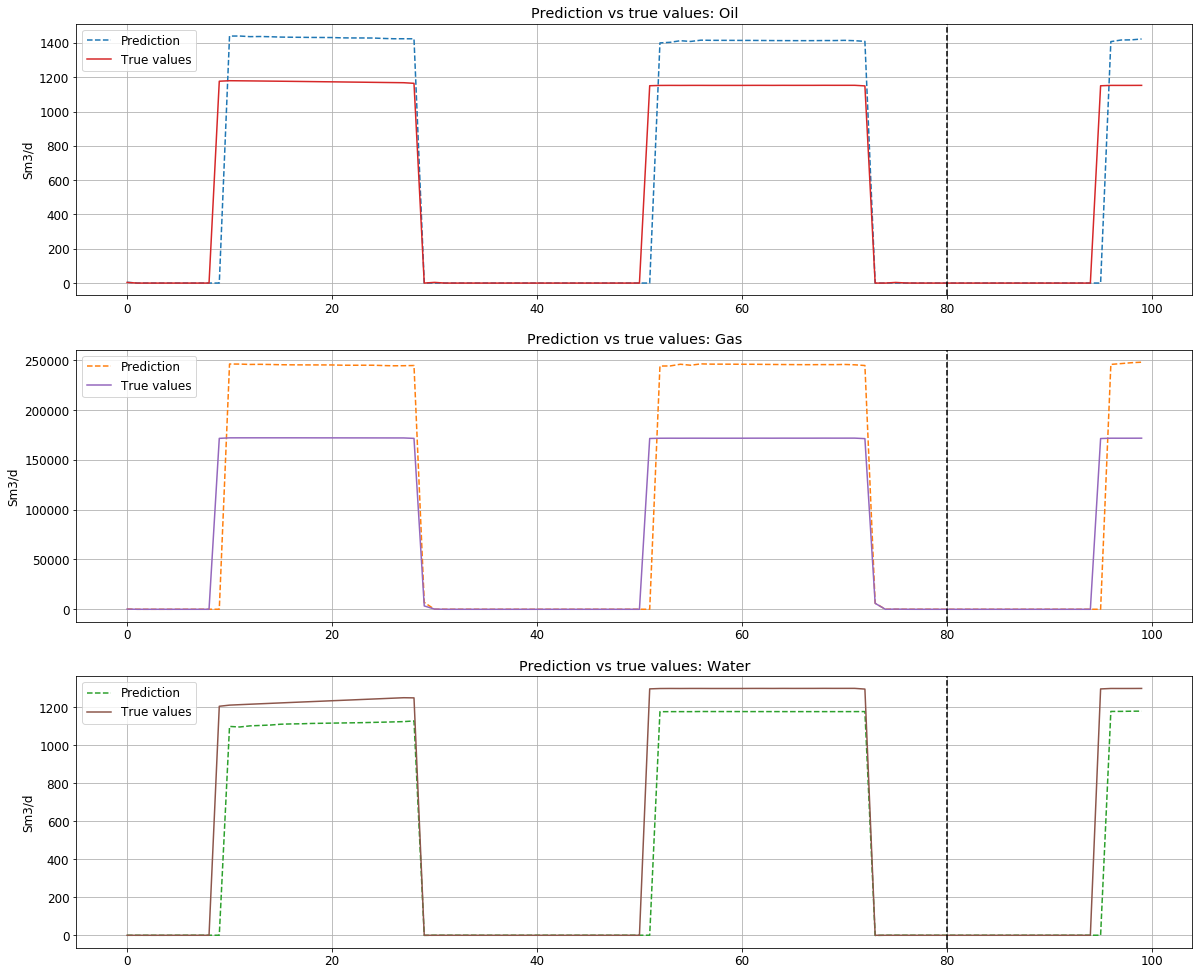

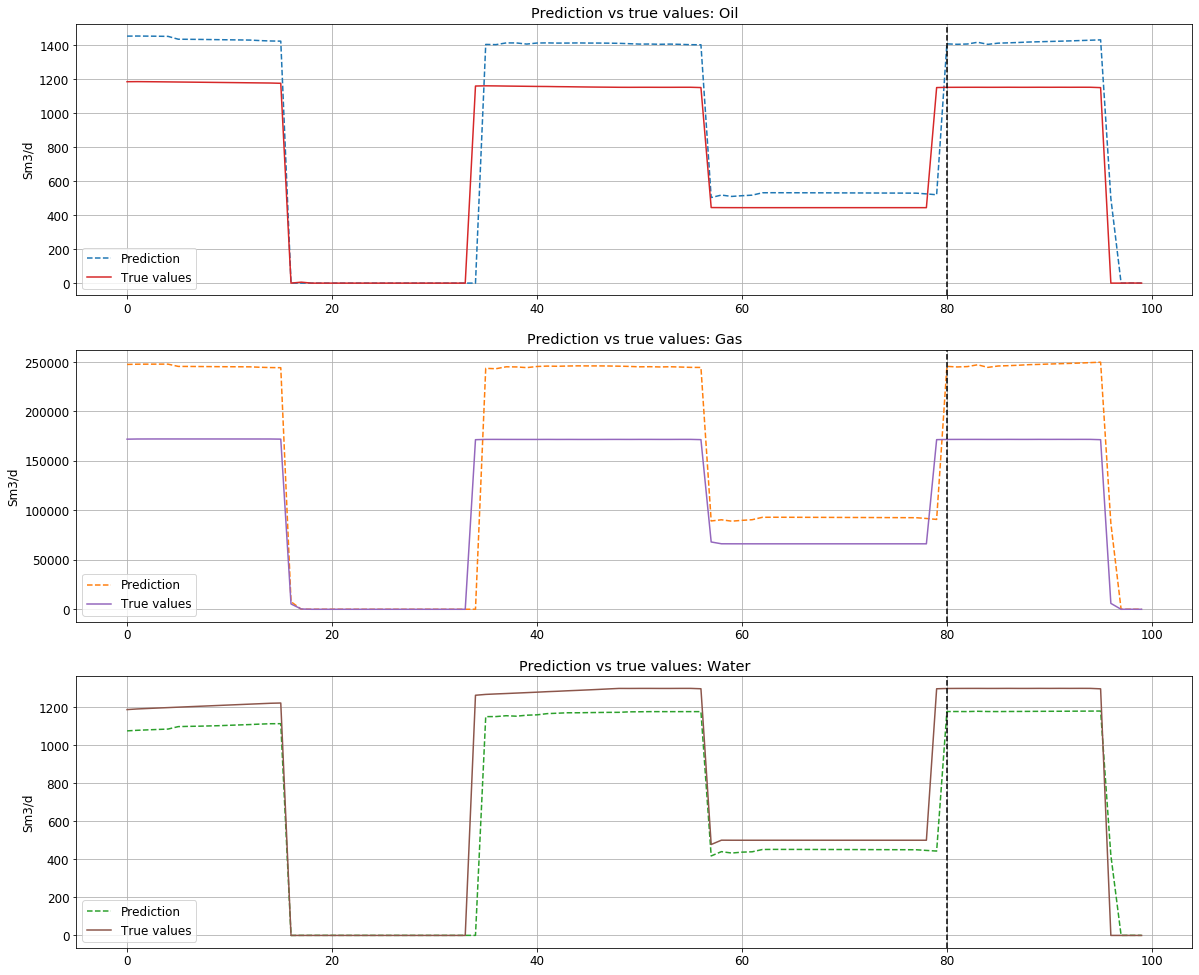

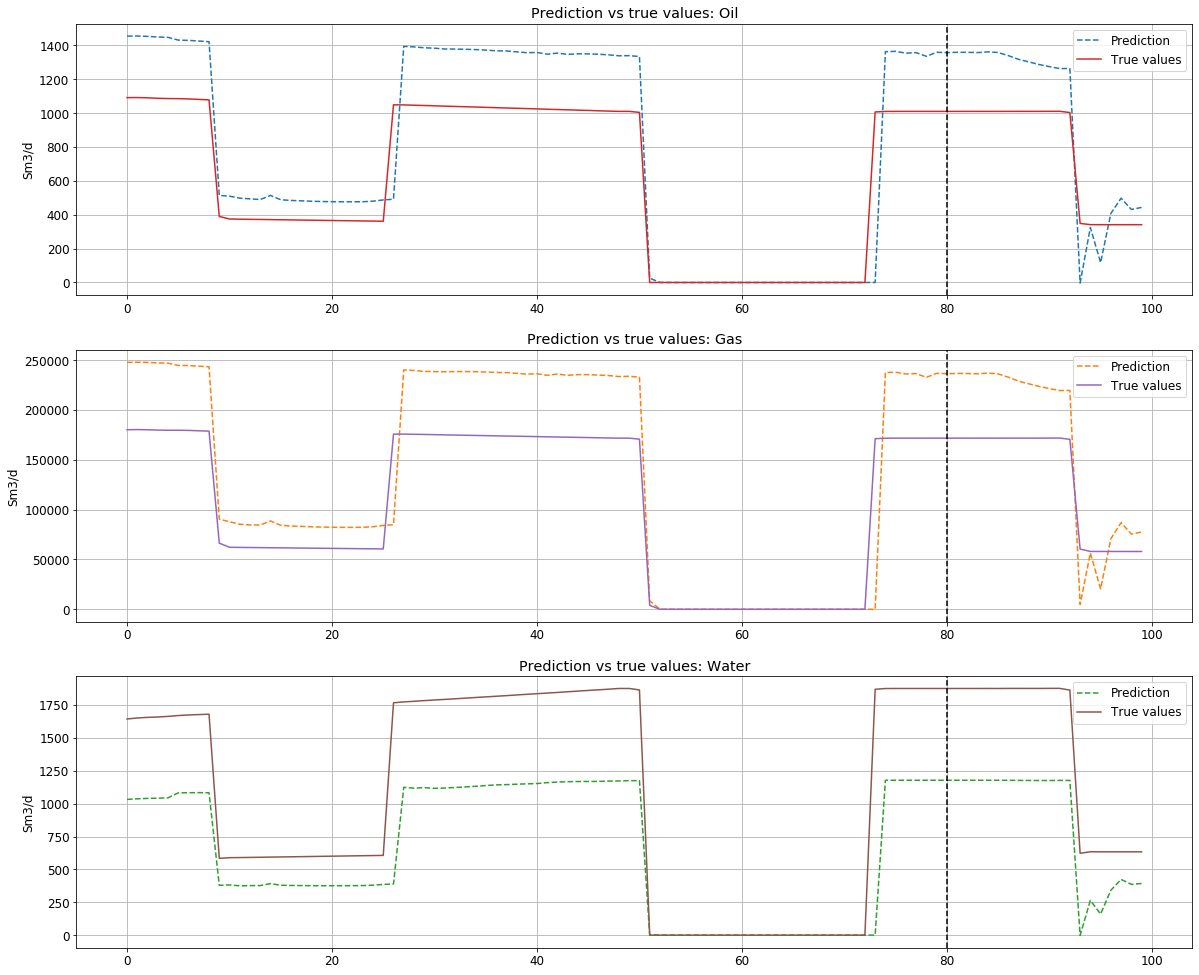

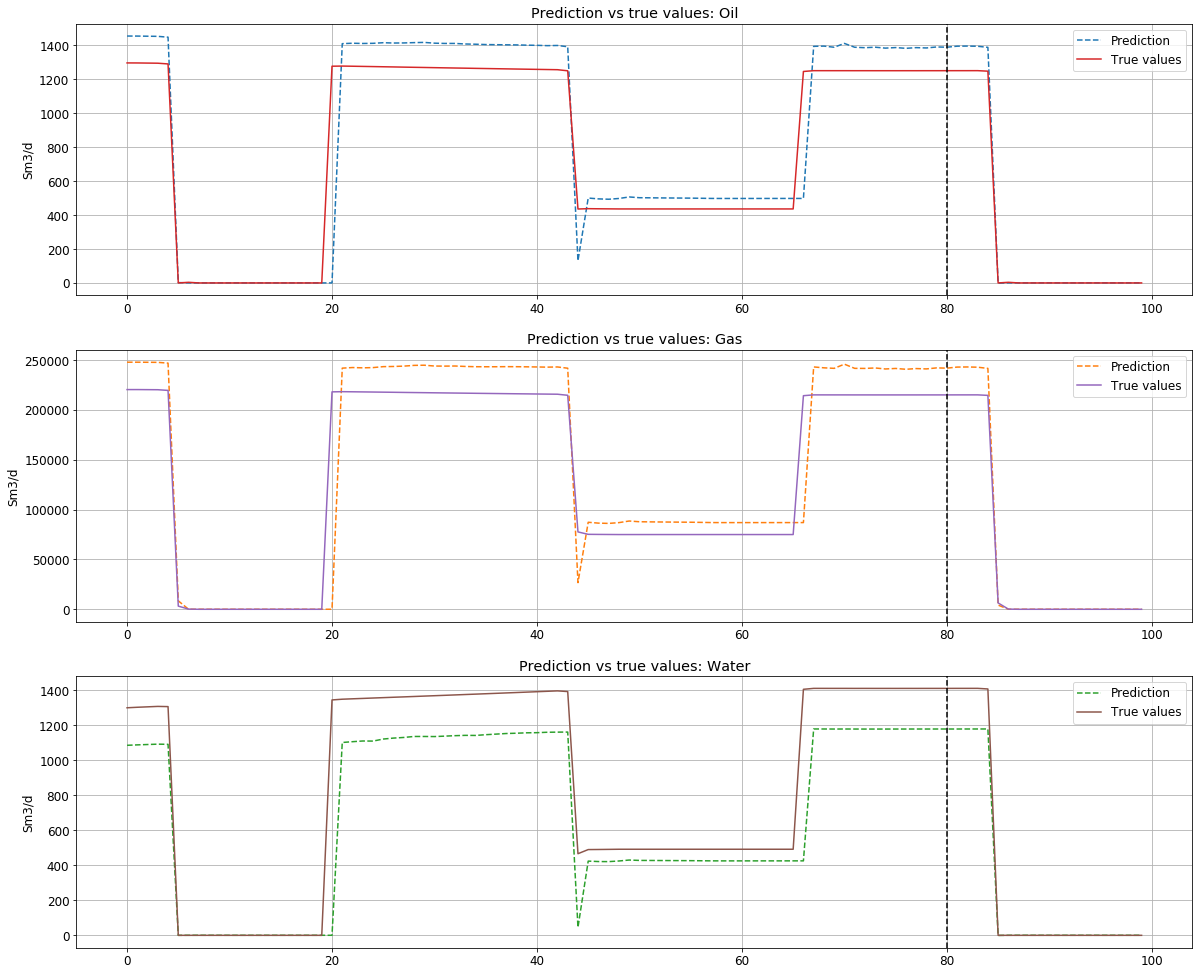

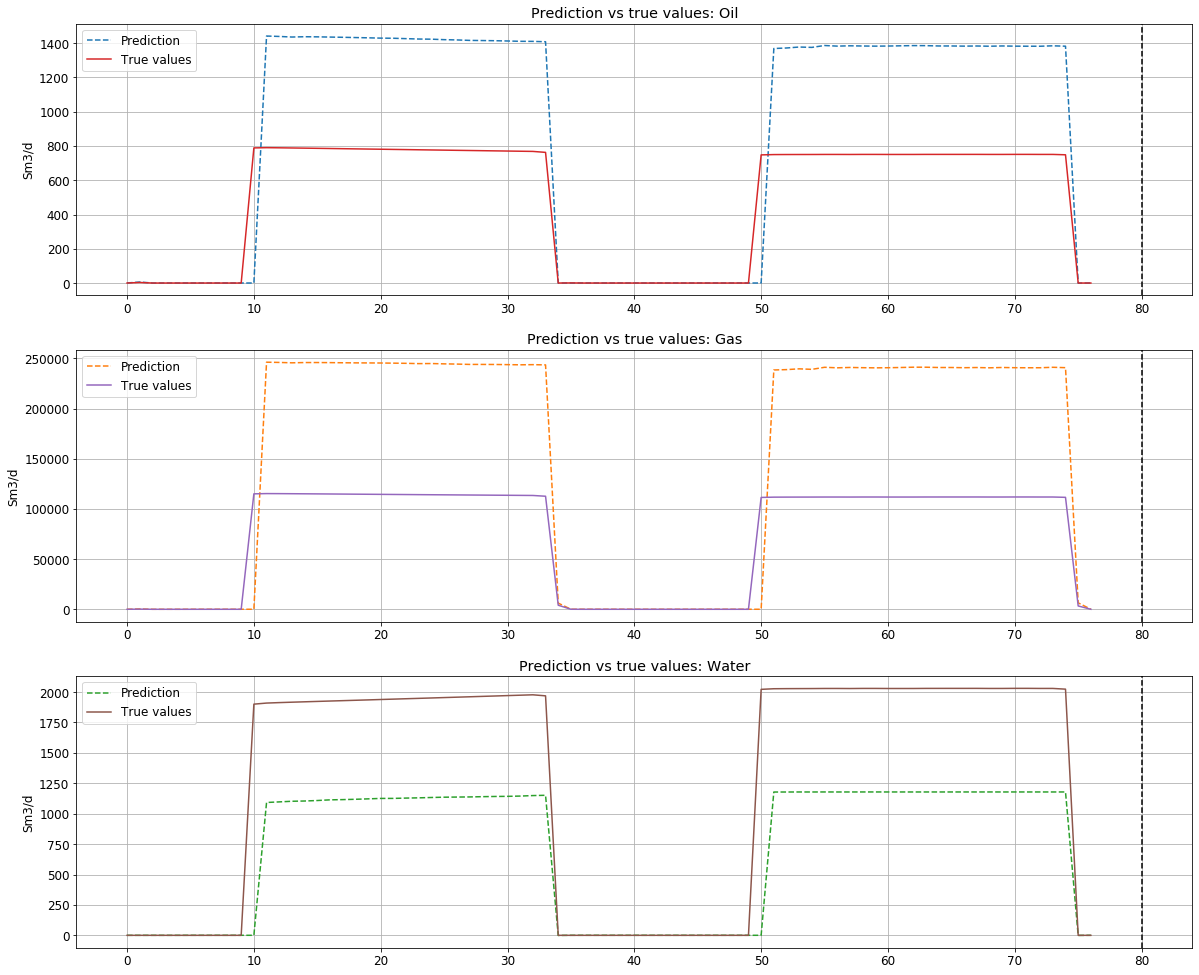

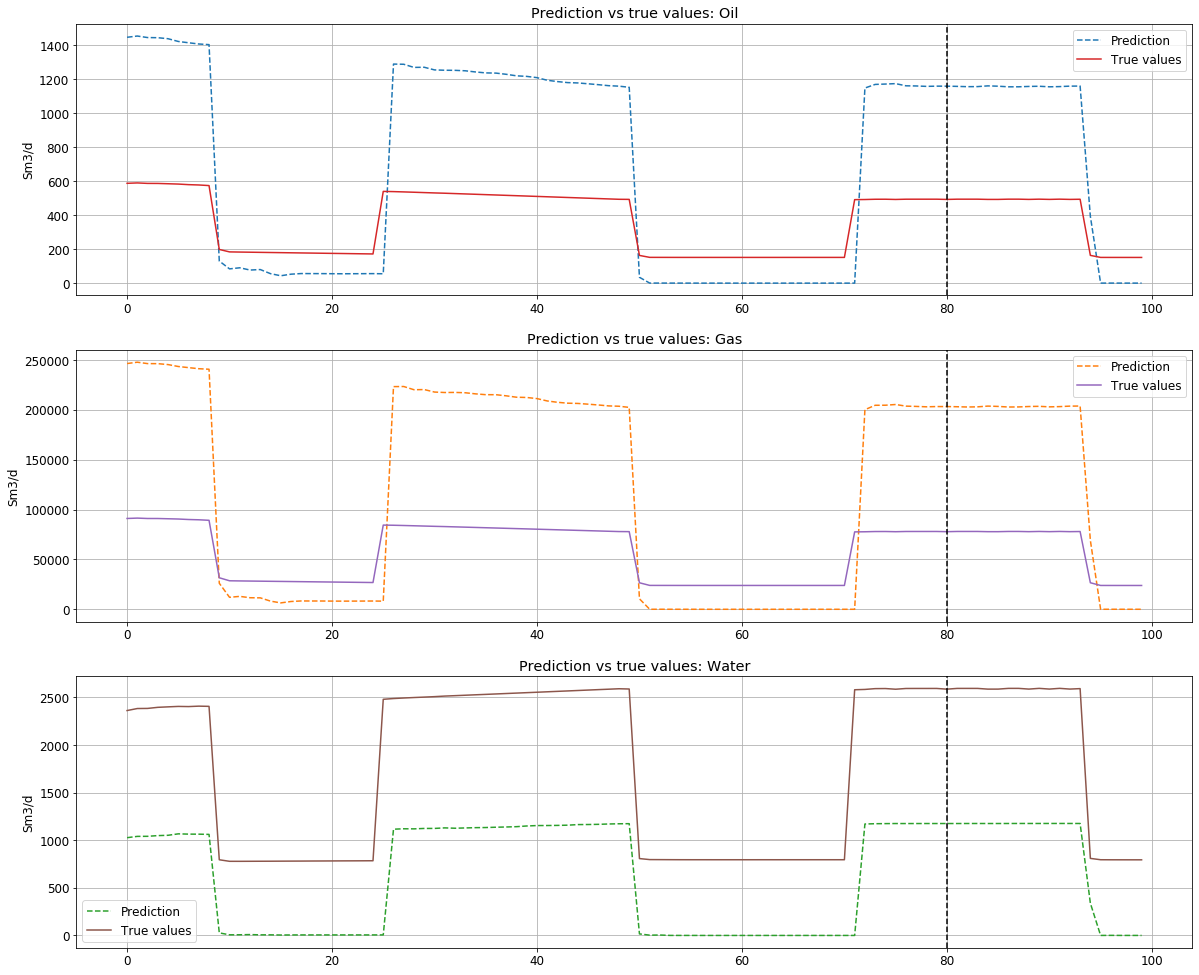

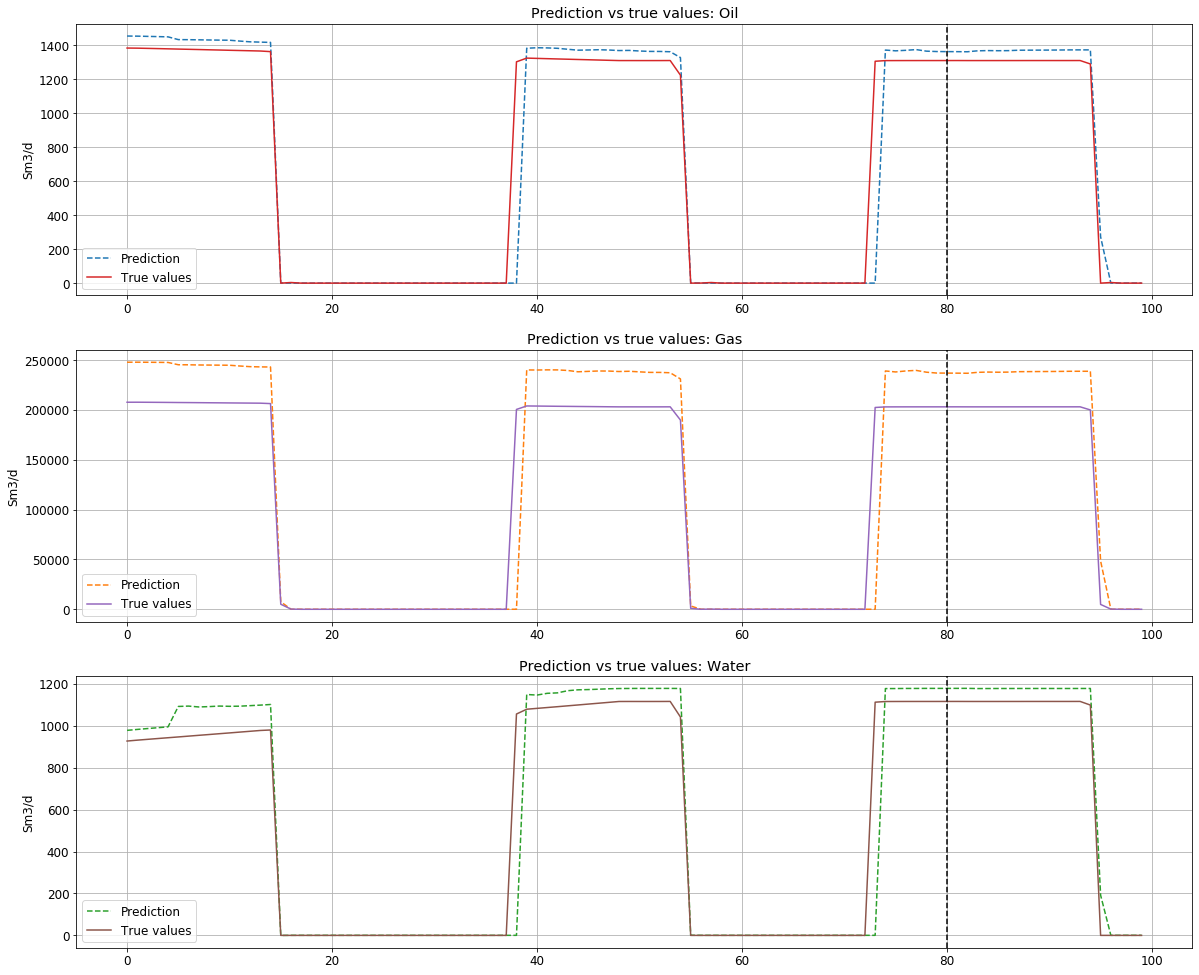

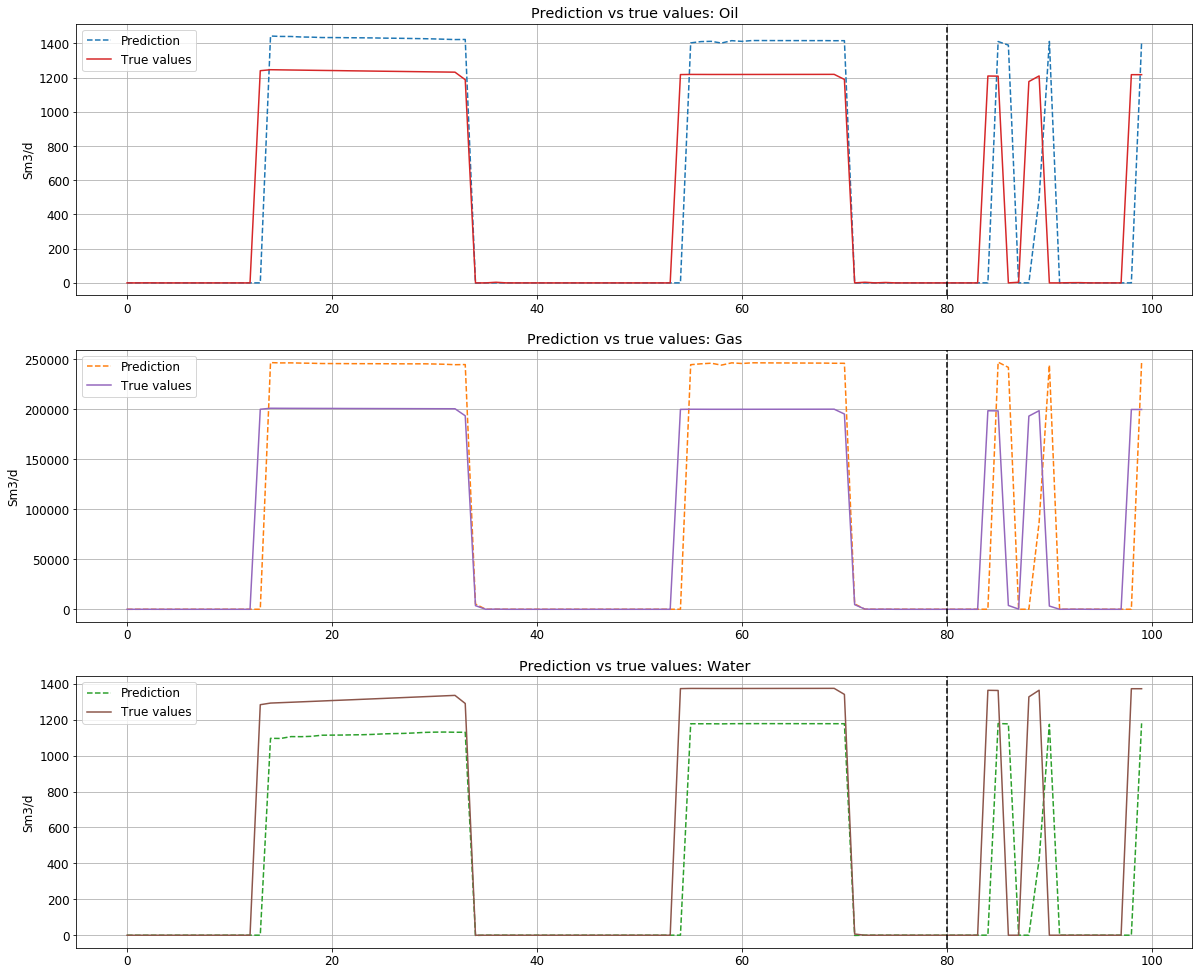

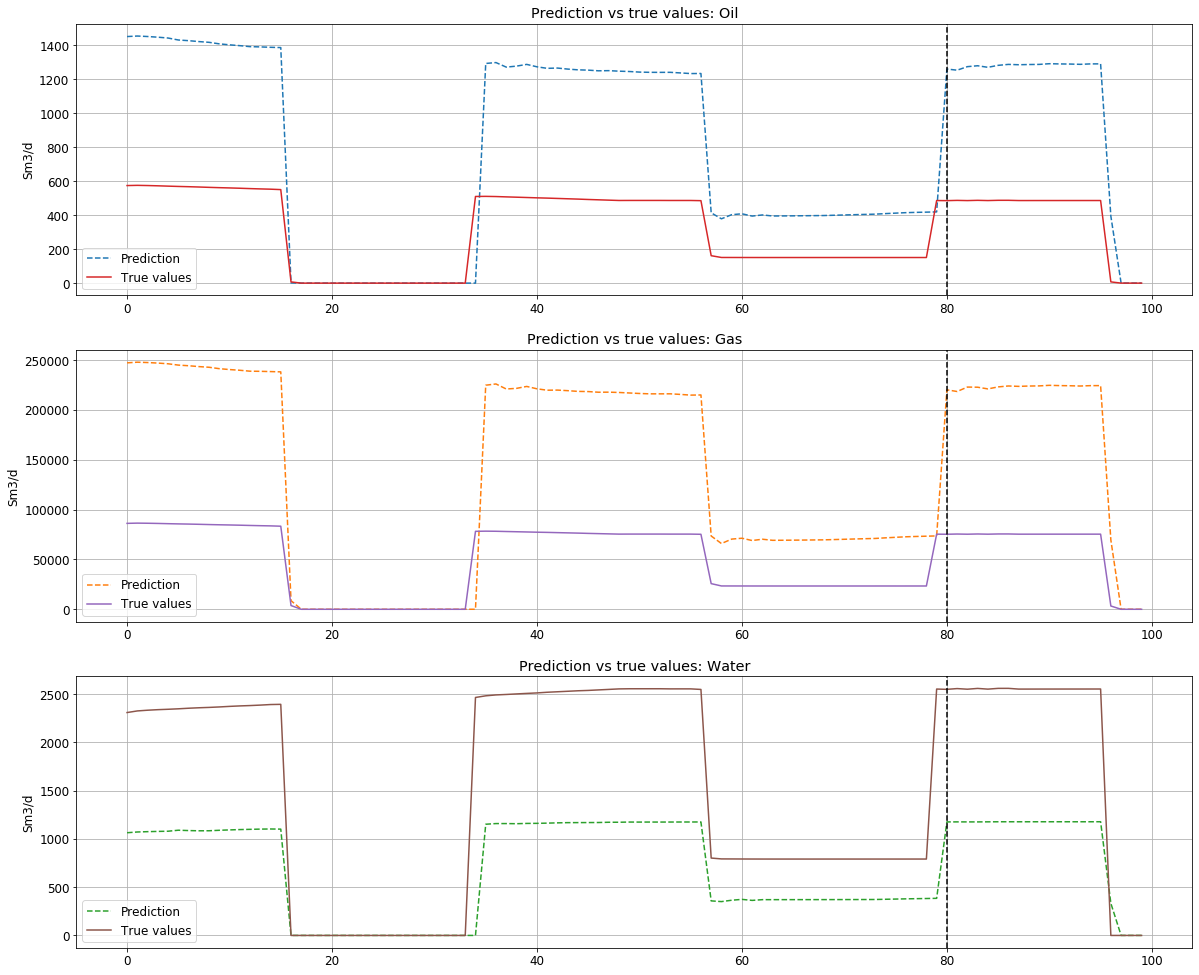

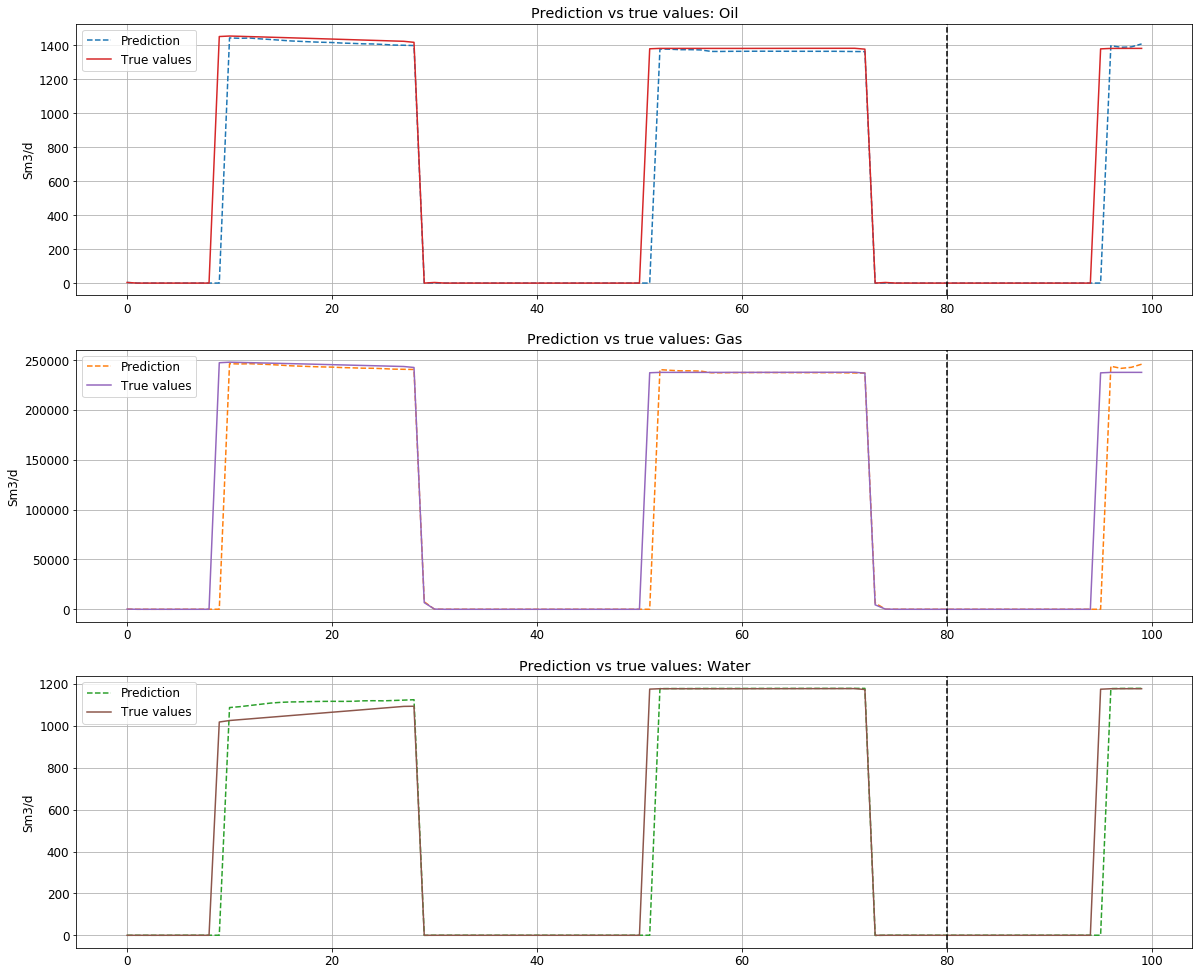

In [167]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [168]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')
print (f'{MODEL_NAME} saved')

MLP-1 saved
